

# Bibliotecas, Importações e Funções



Bibliotecas e Funções

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pandas fiona shapely pyproj rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.6 MB 8.3 MB/s 
     |████████████████████████████████| 7.8 MB 2.2 MB/s 
     |████████████████████████████████| 1.0 MB 15.0 MB/s 


In [ ]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [ ]:
pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Libraries to open 'netcdf' file
import netCDF4 as netcdf

# To pre-process dataframe and use in visualization
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point
import h5py
import ast

## Funções e Paths Auxiliares

In [ ]:
paths_sif_csv = {
    "janeiro-maio": '/content/drive/MyDrive/Dados_OCO-2/sif/csv/janeiro-maio/',
    "junho-setembro":'/content/drive/MyDrive/Dados_OCO-2/sif/csv/Inverno2019/',
    "outubro-novembro": '/content/drive/MyDrive/Dados_OCO-2/sif/csv/outubro-novembro2019/',
    "ultima-semana-agosto": "/content/drive/MyDrive/Dados_OCO-2/sif/csv/ultima-semana-agosto/",
    "ultima-semana-fevereiro": "/content/drive/MyDrive/Dados_OCO-2/sif/csv/ultima-semana-fevereiro/"
}

In [ ]:
paths_csv = {
    "janeiro-maio": '/content/drive/MyDrive/Dados_OCO-2/csv/janeiro-maio2019/',
    "junho-setembro":'/content/drive/MyDrive/Dados_OCO-2/csv/Inverno2019/',
    "outubro-novembro": '/content/drive/MyDrive/Dados_OCO-2/csv/outubro-novembro2019/',
    "ultima-semana-agosto": "/content/drive/MyDrive/Dados_OCO-2/csv/ultima-semana-agosto/",
    "ultima-semana-fevereiro": "/content/drive/MyDrive/Dados_OCO-2/csv/ultima-semana-fevereiro/"
}

In [ ]:
paths_shp = {
    "janeiro-maio": '/content/drive/MyDrive/Dados_OCO-2/shapefiles/janeiro-maio2019/',
    "junho-setembro":'/content/drive/MyDrive/Dados_OCO-2/shapefiles/Inverno2019/',
    "outubro-novembro": '/content/drive/MyDrive/Dados_OCO-2/shapefiles/outubro-novembro2019/',
    "ultima-semana-agosto": "/content/drive/MyDrive/Dados_OCO-2/shapefiles/ultima-semana-agosto/",
    "ultima-semana-fevereiro": "/content/drive/MyDrive/Dados_OCO-2/shapefiles/ultima-semana-fevereiro/"
}

In [ ]:
def create_datetime(lista):
  new_list = []
  for list in lista:
    # print(list)
    # print(type(list))
    conc = "".join(map(str, list))
    # print(conc)
    new_list.append(conc)
  return new_list

In [ ]:
import os

def get_list_files(path):
  directory = path
  files = []
  for filename in os.listdir(directory):
    f = os.path.join(directory, filename)

    if (os.path.isfile(f)) and ('.h5' in f):
      files.append(f)
  return files
    

In [ ]:
def do_oco2_sif_dataframe(oco2_data):
  dim = ['bands','epoch_dimension',  'footprints', 'levels', 'source_files', 'vertices', "date"]
  column_list = list(oco2_data.variables) + list(oco2_data.dimensions)
  xco2_data= pd.DataFrame(columns=column_list)
  print(len(column_list))
  for column in column_list:
    if column == 'date':
      xco2_data[column] = create_datetime(oco2_data[column][:])

    if column not in dim: 
      xco2_data[column] = oco2_data[column][:]

  return xco2_data

In [ ]:
def do_oco2_dataframe(oco2_data):
  dim = ['bands','epoch_dimension',  'footprints', 'levels', 'source_files', 'vertices', "date"]
  column_list = list(oco2_data.variables)
  xco2_data= pd.DataFrame(columns=column_list)
  print(len(column_list))
  for column in column_list:
    if column == 'date':
      xco2_data[column] = create_datetime(oco2_data[column][:])

    if column not in dim: 
      xco2_data[column] = oco2_data[column][:]

  return xco2_data


In [ ]:
def transform_dataframe_on_shapefile_and_return_geodataframe(dataframe, filename):
  print("entrou no transform")

  geometry = [Point(p) for p in zip(dataframe.retrieval_longitude, dataframe.retrieval_latitude)]
  print("criou a geometria")
  crs = 'EPSG:4674'

  geodataframe = gpd.GeoDataFrame(dataframe, crs = crs, geometry = geometry)
  print("criou o geodataframe grande")

  return geodataframe

In [ ]:
def clip_oco2_geodataframe_with_shapefile_and_return_points(limit_shp, geodataframe, filename):

  clipped_amazon = geodataframe.clip(limit_shp)
  status = "empty"
  if clipped_amazon.empty is not True:
    status = "not empty"
    print(type(clipped_amazon))
    print("clipped_amazon")
    drive_folder = '/content/drive/MyDrive/oco-2-standard/shp-legal-amazon/'+ filename + '.shp'
    clipped_amazon.to_file( drive_folder)
    print("Shape criado no path " + drive_folder)

  return status, clipped_amazon

In [ ]:
def create_shp_file_for_study_areas(csv_paths,shp_paths):
  paths = []
  shp_paths = []
  for path_ in shp_paths:
    shp_paths.append(path_[55:102])
  limit_legal_amazon = gpd.read_file('/content/Limites_Amazonia_Legal_2021.shp')
  for path in csv_paths:
    if path[42:89] not in shp_paths:
      filename = path[42:89]
      df = pd.read_csv(path)

      geodataframe = transform_dataframe_on_shapefile_and_return_geodataframe(df, filename)
      status, oco2_data =  clip_oco2_geodataframe_with_shapefile_and_return_points(limit_legal_amazon, geodataframe, filename)

      if status != 'empty':

        drive_folder = '/content/drive/MyDrive/oco-2-standard/shp-legal-amazon/'+ filename + '.csv'
        oco2_data.to_csv(drive_folder)

        paths.append(drive_folder)

        print('File was saved in ' + drive_folder)

In [ ]:
def get_dataframe_convert_and_create_geodataframe(path_list):
  for path in path_list:
    filename = path[61:67]
    dataframe = pd.read_csv(path)
    dataframe['geometry'] = dataframe['geometry_y'].apply(wkt.loads)
    crs = 'EPSG:4674'

    geodataframe = gpd.GeoDataFrame(dataframe, crs = crs)
    geodataframe.set_geometry(col='geometry', inplace=True)

    drive_folder = '/content/drive/MyDrive/terraclimate_forests/' + filename[0:4]
    print(drive_folder)
    check_if_folder_exist(drive_folder)
    geodataframe.to_file(drive_folder + '/shp/' + filename + '.shp')
    print("Arquivo shapefile salvo em " + drive_folder + '/shp/' + filename)

In [ ]:
#posição onde se encontra o nome a string
p = '/content/oco2_LtCO2_190604_B10206Ar_200729195504s.nc4'
p[20:26]

'190604'

In [ ]:
# day_inverno = f[51:57]
# day_verao = f[56:62]

In [ ]:
def create_dataframes_with_dict(path_list, key_path):
  filespath = []
  directory = paths_sif_csv[key_path]
  for filename in os.listdir(directory):
    f = os.path.join(directory, filename)

    if (os.path.isfile(f)):
      day = f[56:62]
      print("day file")
      print(day)
      filespath.append(day)
  d = {}
  for path in path_list:
    if path[20:26] not in filespath:
      print(path)
      data = netcdf.Dataset(path)
      d[path[20:26]] = do_oco2_dataframe(data)
      d[path[20:26]].to_csv( paths_sif_csv[key_path] + 'alldata_' + path[20:26] + '.csv')
      print("CSV criado no path " + paths_sif_csv[key_path] + "alldata_" + path[20:26])
  return d

In [ ]:
def create_big_dataframe_oco2(dataframe_dict,filename, key_path):
  big_dataframe = pd.concat(dataframe_dict.values(), ignore_index=True)
  print(big_dataframe.shape)
  big_path = paths_sif_csv[key_path] + filename
  big_dataframe.to_csv(big_path)
  print("Salvo")
  return big_dataframe

In [ ]:
import os

def get_list_csv_files(path):
  directory = path
  files = []
  for filename in os.listdir(directory):
    f = os.path.join(directory, filename)

    if (os.path.isfile(f)) and ('.csv' in f):
      files.append(f)
  return files

In [ ]:

def get_list_shp_files(path):
  directory = path
  files = []
  for filename in os.listdir(directory):
    f = os.path.join(directory, filename)

    if (os.path.isfile(f)) and ('.shp' in f):
      files.append(f)
  return files

In [ ]:
import os

def get_list_netcdf_files(path):
  directory = path
  files = []
  for filename in os.listdir(directory):
    f = os.path.join(directory, filename)

    if (os.path.isfile(f)) and (f[-1] == '4') and ('.nc4' in f):
      files.append(f)
      print(f)
  return files
    

In [ ]:
def create_geometry_geodataframe(value):
  value_formatted = gpd.GeoDataFrame.from_features(
  [
    {
        "type": "Feature",
        "properties": {},
        "geometry": {
            **value,
            **{"coordinates": value["coordinates"]},
        },
    }
  ]
  )
  return value_formatted

In [ ]:
# clmb_mu['geometry'] = ast.literal_eval(clmb_mu['.geo'])
def formatted_geometry(dataframe_column):
  list_geo = []
  for value in dataframe_column:
    value = ast.literal_eval(value)
    formatted = create_geometry_geodataframe(value)
    list_geo.append(formatted.geometry[0])
  return list_geo


In [ ]:
classPalette = {
    3: '#006400',
    4: '#00ff00',
    5: '#687537',
    9: '#ad4413',
    11: '#45C2A5',
    12: '#B8AF4F',
    15: '#FFD966',
    20: '#C27BA0',
    21: '#fff3bf',
    23: '#DD7E6B',
    24: '#aa0000',
    25: '#ff3d3d',
    30: '#af2a2a',
    32: '#968c46',
    33: '#0000FF',
    39: '#e075ad',
    41: '#e787f8',
    48: '#cd49e4'
}

In [ ]:
classPaletteSt= {
    'Formação Florestal': '#006400',
    'Formação Savânica': '#00ff00',
    'Mangue': '#687537',
    'Silvicultura': '#ad4413',
    'Campo Alagado e Área Pantanosa': '#45C2A5',
    'Formação Campestre': '#B8AF4F',
    'Pastagem': '#FFD966',
    'Cana': '#C27BA0',
    'Mosaico de Agricultura e Pastagem': '#fff3bf',
    'Praia, Duna e Areal': '#DD7E6B',
    'Área Urbana': '#aa0000',
    'Outras áreas não vegetadas': '#ff3d3d',
    'Mineração': '#af2a2a',
    "Apicum": '#968c46',
    'Rio, Lago e Oceano': '#0000FF',
    'Soja': '#e075ad',
    'Outras Lavrouras temporárias': '#e787f8',
    'Outras Lavrouras Perenes': '#cd49e4'
}

https://oco2.gesdisc.eosdis.nasa.gov/data/OCO2_DATA/OCO2_L2_Standard.10r/

In [ ]:
pip install pydap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 4.9 MB/s 
     |████████████████████████████████| 114 kB 50.7 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=26ee9a96952fdb5326efa1a48484fd4a9c54cbbf0c31c94c2adc8f70c14f662e
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [ ]:
from pydap import client
import netCDF4 as nc

# for data-preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot

#EDA

In [ ]:
big_df_evi = pd.read_csv('/content/drive/MyDrive/oco2-standard-modis-evi/big_oco2_evi_2015_2021.csv')

from shapely import wkt
big_df_evi['geometry'] = big_df_evi['geometry'].apply(wkt.loads)
geodf_oco2 = gpd.GeoDataFrame(big_df_evi,crs='EPSG:4627')
geodf_oco2.set_geometry(col='geometry', inplace=True)

In [ ]:
geodf_oco2.isna().sum()

Unnamed: 0      0
system_ind      0
DayOfYear       0
DetailedQA      0
EVI             0
NDVI            0
RelativeAz      0
SolarZenit      0
SummaryQA       0
ViewZenith      0
sur_refl_b      0
sur_refl_1      0
sur_refl_2      0
sur_refl_3      0
index_righ      0
xco2            0
xco2_uncer      0
sif             0
sif_unc         0
out_flag        0
sound_id        0
latitude        0
longitude       0
land_w_ind      0
land_frac       0
geometry        0
sound_mode    127
dtype: int64

In [ ]:
geodf_oco2 = geodf_oco2.drop(columns=['sound_mode'])

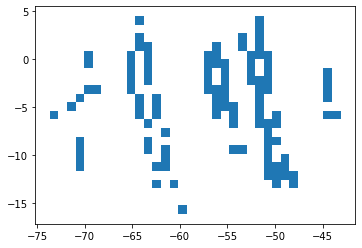

In [ ]:
geodf_oco2.plot()

In [ ]:
print(geodf_oco2.shape)

(127, 26)



#Funções e Bibliotecas da Rede SOM

Irei utilizar na minha dissertação dados provenientes do satélite OCO-2 e do Mapeamento de uso do Solo realizado pelo Mapbiomas. O interesse nesses dados é encontrar possíveis agrupamentos dos dados que caracterizem as classes do Mapbiomas, de modo a entender se há relação entre a quantidade de CO2 atmosférico e o uso do solo. O entendimento dessa relação agrupa elementos da terra, como uso e mudança do solo e elementos da atmosfera, como precipitação, pressão atmosférica, temperatura, entre outros.  Esse estudo será realizado em toda a região da Amazônia Legal. 

Neste Notebook serão utilizados para este estudo apenas dados de uso da solo (mapbiomas) e elementos pressão e co2 da atmosfera. Futuramente outros dados do estudo do solo e atmosfera serão utilizados para um entendimento mais detalhado das relações ditas acima. 

Os dados do OCO-2 utilizados nesse notebook no período do Inverno de 2019 foram importados via API do Earth Open Data, maior informação sobre os dados podem ser encontrados nesse [link](https://disc.gsfc.nasa.gov/datasets/OCO2_L2_Lite_FP_10r/summary) e o download dos dados e criação dos dataframes foram realizados neste [notebook](https://colab.research.google.com/drive/19wAiMcJSOhBmkkXtd3-pbByXoGQ3YfLF?usp=sharing).

Já os dados do Mapbiomas se encontram disponibilizados via Google Earth Engine, foi utilizado os dados do ano de 2019 e da coleção 6, para mais detalhes da coleção acesse [aqui](https://mapbiomas-br-site.s3.amazonaws.com/downloads/Colecction%206/Cod_Class_legenda_Col6_MapBiomas_BR.pdf). Caso queira saber mais sobre o mapbiomas, acesse [AQUI](https://mapbiomas.org/o-projeto).

A junção dos dados do Mapbiomas e os dados do OCO-2 foram feitas a partir dos recursos da Api do Google Earth Engine em Python, onde foi utilizado o algoritmo de vizinhos mais próximos para colocalizar os dados do Mapbiomas com os dados do OCO-2. Essa junção foi realizada neste [notebook](https://colab.research.google.com/drive/1PM5xyH7ZPO1Btj0IRaNMNASMVwh69voZ?usp=sharing).

Aqui será utilizado quatro recortes de dados, esses estâo enumerados e descritos abaixo.
Foi realizado o recorte da qualidade dos dados provenientes do OCO-2 nos conjuntos 3 e 4. De acordo com a documentação do OCO-2, os dados contém índices de qualidade a partir da coluna *'xco2_quality_flag'*, onde o valor é **`0`** para dados com alta qualidade e **`1`** para dados de baixa qualidade. 

Neste notebook será utilizado a rede neural SOM com os dados de CO2 atmosférico (ppm), componentes da pressão atmosférica (hPa), classes do Mapbiomas e outros dados de qualidade e sensores advindos do OCO-2. 

1. 01 de junho de 2019 a 31 de setembro de 2019
2. 20 a 31 de agosto de 2019  
3. 20 a 31 de agosto de 2019 com filtro de qualidade `xco2_quality_flag=0` .
4. 01 de junho de 2019 a 31 de setembro de 2019 com filtro de qualidade `xco2_quality_flag=0` .

A análise exploratória dos dados se encontra neste [notebook](https://colab.research.google.com/drive/1IpndRPfIx1LTd3QRoL9ReY8gH39Y9I7Y?usp=sharing)

## Importação Geral

In [ ]:
pip install plotnine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install minisom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9016 sha256=3f50ac91f9a504f5d7f78d9df2440a3a1ae9b603a518855453368ff29edbd9bc
  Stored in directory: /root/.cache/pip/wheels/6d/4e/9e/a95c14a232a196c22d9c04b221ff5d25461a1a4c55339c61db
Successfully built minisom


In [ ]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install geobr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 928 kB 8.6 MB/s 
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.12.2
    Uninstalling geopandas-0.12.2:
      Successfully uninstalled geopandas-0.12.2


In [ ]:
import geopandas as gpd

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from plotnine import *
import geobr

from sklearn.preprocessing import LabelEncoder

from minisom import MiniSom

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
import seaborn as sns

# importar os pacotes necessários

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.under_sampling import RandomUnderSampler

# configurar o estilo dos gráficos com o Seaborn
sns.set_style('dark')

In [ ]:
def print_error(som_model, data) -> None:
    """Apresenta os erros de quantização e topográficos 
    de uma instância SOM treinada
    

    Args:
        som_model (minisom.MiniSom): Instância MiniSom treinada
        
        data (np.ndarray): array n-dimensional com os dados utilizados como entrada 
        nas funções de erro
    Returns:
        None
    """
    
    for method in ['quantization_error', 'topographic_error']:
        print(f'{method}: {getattr(som_model, method)(data)}')
        

def manual_random_training(som_model, data, max_iter) -> pd.DataFrame:
    """Função para treinamento da rede SOM com amostragem aleatória.
    
    Args:
        som_model (minisom.MiniSom): Instância MiniSom treinada

        data (np.ndarray): array n-dimensional com os dados utilizados no treinamento
        
        max_iter (int): Quantidade máxima de iterações
    
    Returns:
        pd.DataFrame: Tabela com os erros de quantização e topográficos gerados
    See:
        https://github.com/JustGlowing/minisom/blob/master/examples/BasicUsage.ipynb
    """
    
    errors = {
        'qerror': [],
        'terror': []
    }
    
    for idx in range(max_iter):
        data_random = data[np.random.randint(len(data))]
        
        som_model.update(data_random, som_model.winner(data_random), idx, max_iter)
        
        errors['qerror'].append(som_model.quantization_error(data))
        errors['terror'].append(som_model.topographic_error(data))
    return pd.DataFrame(errors)

In [ ]:
def test_som_factory_with_different_learning_rate(learning_rates: list, data: np.ndarray, X_len) -> tuple:
    """Função para gerar múltiplos SOM variando a taxa de aprendizado
    
    Args:
        larning_rates (list): Lista com diversas taxas de aprendizado
        
        data (np.ndarray): array n-dimensional com os dados utilizados no treinamento
        
    Returns:
        tuple: Tuple contendo tabela com os valores de erros de quantização e topográficos para cada
        taxa de aprendizado inserida e os modelos ajustados    
    """
    
    models = {}
    results = []
    for lr in learning_rates:
        _som = MiniSom(10, 10, X_len, learning_rate=lr)
        _lr_error = manual_random_training(_som, data, 1000)
        _lr_error['label'] = lr
        _lr_error['label'] = pd.Categorical(_lr_error['label']).astype(str)
        
        models[lr] = _som
        
        results.append(_lr_error)
    return pd.concat(results), models

### Funções que serão utilizadas para visualização do resultado da rede

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

from bokeh.colors import RGB
from bokeh.io import curdoc, show, output_notebook
from bokeh.transform import factor_mark, factor_cmap
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, output_file

# display matplotlib plots in notebook
%matplotlib inline
# display bokeh plot in notebook
output_notebook()

In [ ]:
def plot_clusters_for_som(X, cluster_index, position_latitude, position_longitude):
  plt.figure(figsize=(12, 6), dpi=80)
  teste = []

  # plotting the clusters using the first 2 dimentions of the X
  for c in np.unique(cluster_index):
    plt.scatter(X[cluster_index == c, position_longitude],
                  X[cluster_index == c, position_latitude], label='cluster='+str(c), alpha=.7)

  # # plotting centroids
  # for centroid in som.get_weights():
  #     plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
  #                 s=80, linewidths=35, color='k', label='centroid')
  # plt.legend(loc='best');
  plt.title("Self Organising Map - Clustering")
  plt.xlabel("Longitude")
  plt.ylabel("Latitude")

  teste.append(c)

  return teste

In [ ]:
def create_umatrix_hitmap_heatmap(som, X, enum_errors, y):
# plots
  fig, ax = plt.subplots(3, 1, figsize=(14, 30), dpi=120)
  eq = som.quantization_error(X)
  # et = som.topographic_error(X)

  #u-matrix
  ax[0].imshow(som.distance_map().T, cmap='Blues')

  markers = {'Formação Florestal': 'o', 'Formação Savânica': 'v', 'Formação Campestre': '>', 'Pastagem': '<', 'Soja': '1', 'Mangue': "8", "Rio, Lago e Oceano": "s", "Mosaico de Agricultura e Pastagem": "P", "Apicum": "*", "Campo Alagado e Área Pantanosa": "+", "Área Urbana": "D", 'Silvicultura': "d", 'Outras Lavrouras temporárias': "X", 'Outras áreas não vegetadas': "4", "Praia, Duna e Areal": '^', 'Outras Lavrouras Perenes': "4", "Cana": "1", 'Mineração': '8' }
  colors = {'Formação Florestal': 'C2', 'Formação Savânica': 'C8', 'Formação Campestre': 'C4', 'Pastagem': 'C1', 'Soja': 'C6', 'Mangue': "C9", "Rio, Lago e Oceano": "C0", "Mosaico de Agricultura e Pastagem": "C7", "Apicum": "C5", "Campo Alagado e Área Pantanosa": "C3", "Área Urbana": "#ffffff", 'Silvicultura': "#000000", 'Outras Lavrouras temporárias': "violet", 'Outras áreas não vegetadas': "aqua", "Praia, Duna e Areal": 'green', 'Outras Lavrouras Perenes': "blue", "Cana": "black", 'Mineração': 'red' }
  for i, x in enumerate(X):
    if i not in enum_errors:
      w = som.winner(x)
      marker = markers[y[i]]
      color = colors[y[i]]
      ax[0].plot(w[0], w[1], marker, markerfacecolor='None',
              markeredgecolor=color, markersize=12, markeredgewidth=2)
  ax[0].set_title('SOM U-Matrix Mapbiomas\nlr: %s, sig: %s, erro_q: %.2f\nneighborhood_function: %s'%(lr, sig, eq, func))

  #hitmap
  freq = som.activation_response(X).astype(int)
  cmap = ax[1].imshow(freq.T, cmap='PuBu') 
  for (i, j), z in np.ndenumerate(freq.T):
      color = 'w' if z > freq.T.max()/2 else 'k'
      ax[1].text(j, i, z, ha='center', va='center', color=color)
  ax[1].set_title('SOM Hitmap Mapbiomas\nlr: %s, sig: %s, erro_q: %.2f\nneighborhood_function: %s'%(lr, sig, eq, func))

  #heatmap
  dm = som.distance_map()
  ax[2].imshow(dm, cmap="Reds")
  for i in range(dm.shape[0]):
      for j in range(dm.shape[1]):
          color = 'w' if dm[i][j] > dm.max()/2 else 'k'
          ax[2].text(j, i, '%.2f'%dm[i][j], ha='center', va='center', color=color)
  ax[2].set_title('Heatmap Mapbiomas\nlr: %s, sig: %s, erro_q: %.2f\nneighborhood_function: %s'%(lr, sig, eq, func))

In [ ]:
def create_hexagonal_topology_with_markers(som, X, y, xx, yy, umatrix, weights, legend_elements, enum_errors, filename):
  f = plt.figure(figsize=(20,20))
  ax = f.add_subplot(111)

  ax.set_aspect('equal')

  # iteratively add hexagons
  for i in range(weights.shape[0]):
      for j in range(weights.shape[1]):
          wy = yy[(i, j)] * np.sqrt(3) / 2
          hex = RegularPolygon((xx[(i, j)], wy), 
                              numVertices=6, 
                              radius=.95 / np.sqrt(3),
                              facecolor=cm.Blues(umatrix[i, j]), 
                              alpha=.8, 
                              edgecolor='black')
          ax.add_patch(hex)

  markers = {'Formação Florestal': 'o', 'Formação Savânica': 'v', 'Formação Campestre': '>', 'Pastagem': '<', 'Soja': '1', 'Mangue': "8", "Rio, Lago e Oceano": "s", "Mosaico de Agricultura e Pastagem": "P", "Apicum": "*", "Campo Alagado e Área Pantanosa": "+", "Área Urbana": "D", 'Silvicultura': "d", 'Outras Lavrouras temporárias': "X", 'Outras áreas não vegetadas': "4", "Praia, Duna e Areal": '^', 'Outras Lavrouras Perenes': "4", "Cana": "1", 'Mineração': '8' }
  colors = {'Formação Florestal': 'C2', 'Formação Savânica': 'C8', 'Formação Campestre': 'C4', 'Pastagem': 'C1', 'Soja': 'C6', 'Mangue': "C9", "Rio, Lago e Oceano": "C0", "Mosaico de Agricultura e Pastagem": "C7", "Apicum": "C5", "Campo Alagado e Área Pantanosa": "C3", "Área Urbana": "#ffffff", 'Silvicultura': "#000000", 'Outras Lavrouras temporárias': "violet", 'Outras áreas não vegetadas': "aqua", "Praia, Duna e Areal": 'green', 'Outras Lavrouras Perenes': "blue", "Cana": "black", 'Mineração': 'red' }

  for i, x in enumerate(X):
    if i not in enum_errors:
      w = som.winner(x)
      # place a marker on the winning position for the sample xx
      wx, wy = som.convert_map_to_euclidean(w) 
      wy = wy * np.sqrt(3) / 2
      marker = markers[y[i]]
      color = colors[y[i]]
      plt.plot(wx, wy, 
              marker, 
              markerfacecolor='None',
              markeredgecolor=color, 
              markersize=12, 
              markeredgewidth=2
              )
      

  xrange = np.arange(weights.shape[0])
  yrange = np.arange(weights.shape[1])
  plt.xticks(xrange-.5, xrange)
  plt.yticks(yrange * np.sqrt(3) / 2, yrange)

  divider = make_axes_locatable(plt.gca())
  ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
  cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, 
                              orientation='vertical', alpha=.8)
  cb1.ax.get_yaxis().labelpad = 16
  cb1.ax.set_ylabel('distance from neurons in the neighbourhood',
                    rotation=270, fontsize=16)
  plt.gcf().add_axes(ax_cb)

  ax.legend(handles=legend_elements, bbox_to_anchor=(0.1, 1.08), loc='best', 
            borderaxespad=0., ncol=3, fontsize=14)

  plt.savefig(filename, format='png')
  plt.show()

In [ ]:
def create_hexagonal_topology__makers_html(som, X, y, xx, yy, umatrix, weights, legend_elements, enum_errors):

  hex_centre_col, hex_centre_row = [], []
  hex_colour = []
  label = []

  # define labels
  SPECIES = y.unique()

  for i in range(weights.shape[0]):
      for j in range(weights.shape[1]):
          wy = yy[(i, j)] * np.sqrt(3) / 2
          hex_centre_col.append(xx[(i, j)])
          hex_centre_row.append(wy)
          hex_colour.append(cm.GnBu(umatrix[i, j]))

  weight_x, weight_y = [], []
        
  for cnt, i in enumerate(X):
    if cnt not in enum_errors:

      w = som.winner(i)
      wx, wy = som.convert_map_to_euclidean(xy=w)
      wy = wy * np.sqrt(3) / 2
      weight_x.append(wx)
      weight_y.append(wy)
      label.append(y[cnt])
      
  # convert matplotlib colour palette to bokeh colour palette
  hex_plt = [(255 * np.array(i)).astype(int) for i in hex_colour]
  hex_bokeh = [RGB(*tuple(rgb)).to_hex() for rgb in hex_plt]

  # initialise figure/plot
  fig = figure(title="SOM: Hexagonal Topology",
              plot_height=900, plot_width=1100,
              match_aspect=True,
              tools="wheel_zoom,save,reset", hidpi=True)

  # create data stream for plotting
  source_hex = ColumnDataSource(
      data = dict(
          x=hex_centre_col,
          y=hex_centre_row,
          c=hex_bokeh
      )
  )

  source_pages = ColumnDataSource(
      data=dict(
          wx=weight_x,
          wy=weight_y,
          species=label
      )
  )

  # define markers
  MARKERS = [ 'asterisk', 'circle', 'circle_cross', 'circle_dot', 'circle_x', 'circle_y', 'cross', 'dash', 'diamond', 'diamond_cross', 'diamond_dot', 'dot', 'hex', 'hex_dot', 'inverted_triangle', 'plus', 'square', 'square_cross', 'square_dot', 'square_pin', 'square_x', 'star', 'star_dot', 'triangle', 'triangle_dot', 'triangle_pin', 'x', 'y' ]

  # add shapes to plot
  fig.hex(x='x', y='y', source=source_hex,
          size=100 * (.95 / np.sqrt(3)),
          alpha=.8,
          line_color='black',
          fill_color='c')

  fig.scatter(x='wx', y='wy', source=source_pages, 
              legend_field='species',
              size=20, 
              marker=factor_mark(field_name='species', markers=MARKERS, factors=SPECIES),
              color=factor_cmap(field_name='species', palette='Category20_13', factors=SPECIES))

  # add hover-over tooltip
  fig.add_tools(HoverTool(
      tooltips=[
          ("label", '@species'),
          ("(x,y)", '($x, $y)')],
      mode="mouse", 
      point_policy="follow_mouse"
  ))

  fig.legend.location = 'bottom_right'
  show(fig)

In [ ]:
classPalette = {
    3: '#006400',
    4: '#00ff00',
    5: '#687537',
    9: '#ad4413',
    11: '#45C2A5',
    12: '#B8AF4F',
    15: '#FFD966',
    20: '#C27BA0',
    21: '#fff3bf',
    23: '#DD7E6B',
    24: '#aa0000',
    25: '#ff3d3d',
    30: '#af2a2a',
    32: '#968c46',
    33: '#0000FF',
    39: '#e075ad',
    41: '#e787f8',
    48: '#cd49e4'
}

In [ ]:
classPaletteSt= {
    'Formação Florestal': '#006400',
    'Formação Savânica': '#00ff00',
    'Mangue': '#687537',
    'Silvicultura': '#ad4413',
    'Campo Alagado e Área Pantanosa': '#45C2A5',
    'Formação Campestre': '#B8AF4F',
    'Pastagem': '#FFD966',
    'Cana': '#C27BA0',
    'Mosaico de Agricultura e Pastagem': '#fff3bf',
    'Praia, Duna e Areal': '#DD7E6B',
    'Área Urbana': '#aa0000',
    'Outras áreas não vegetadas': '#ff3d3d',
    'Mineração': '#af2a2a',
    "Apicum": '#968c46',
    'Rio, Lago e Oceano': '#0000FF',
    'Soja': '#e075ad',
    'Outras Lavrouras temporárias': '#e787f8',
    'Outras Lavrouras Perenes': '#cd49e4'
}

In [ ]:
 {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" }

{3.0: 'Formação Florestal',
 4.0: 'Formação Savânica',
 12.0: 'Formação Campestre',
 15.0: 'Pastagem',
 39.0: 'Soja',
 5.0: 'Mangue',
 33.0: 'Rio, Lago e Oceano',
 21.0: 'Mosaico de Agricultura e Pastagem',
 32.0: 'Apicum',
 11.0: 'Campo Alagado e Área Pantanosa',
 24.0: 'Área Urbana',
 9.0: 'Silvicultura',
 41.0: 'Outras Lavrouras temporárias',
 25.0: 'Outras áreas não vegetadas',
 48.0: 'Outras Lavrouras Perenes',
 20.0: 'Cana',
 30: 'Mineração',
 23: 'Praia, Duna e Areal'}

In [ ]:
def normalize_dataframe(df):
  df_min_max_scaled = df.copy() 
  for column in df_min_max_scaled.columns: 
      df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())     
  return df_min_max_scaled

In [ ]:
legend_elements = [Line2D([0], [0], marker='o', color='C2', label='Formação Florestal',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='<', color='C1', label='Pastagem',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='v', color='C8', label='Formação Savânica',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='1', color='C6', label='Soja',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='>', color='C4', label='Formação Campestre',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='+', color='C3', label='Campo Alagado e Área Pantanosa',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='s', color='C0', label='Rio, Lago e Oceano',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='P', color='C7', label='Mosaico de Agricultura e Pastagem',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='X', color='pink', label='Outras Lavrouras Temporárias',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='d', color='#000000', label='Silvicultura',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='D', color='violet', label='Área Urbana',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='4', color='aqua', label='Outras áreas não vegetadas',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                    Line2D([0], [0], marker='8', color='red', label='Mangue',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='s', color='black', label='Outras Lavrouras Perenes',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='p', color='C9', label="Praia, Duna e Areal",
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='X', color='C5', label="Cana",
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='8', color='green', label='Mineração',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2)
                   ]


In [ ]:
def get_results_from_model_and_save(X, list_columns, cluster_index, df_origin):

  df_result = pd.DataFrame(X, columns=list_columns)
  df_result['cluster_index'] = cluster_index
  # df_result['classes'] = df_origin['classification_2019']
  df_result['index'] = df_origin['index']
  df_result['geometry'] = df_origin['geometry']

  # df_result.to_csv()

  return df_result

# Importação e Preparação dos Dados OCO-2

Dados do satélite OCO-2 para o período entre os dias 01-08-2015 e 31-09-2021

In [ ]:
print(geodf_oco2.isna().sum())
print(geodf_oco2.shape)

Unnamed: 0    0
system_ind    0
DayOfYear     0
DetailedQA    0
EVI           0
NDVI          0
RelativeAz    0
SolarZenit    0
SummaryQA     0
ViewZenith    0
sur_refl_b    0
sur_refl_1    0
sur_refl_2    0
sur_refl_3    0
index_righ    0
xco2          0
xco2_uncer    0
sif           0
sif_unc       0
out_flag      0
sound_id      0
latitude      0
longitude     0
land_w_ind    0
land_frac     0
geometry      0
dtype: int64
(127, 26)


In [ ]:
geodf_oco2.columns

Index(['Unnamed: 0', 'system_ind', 'DayOfYear', 'DetailedQA', 'EVI', 'NDVI',
       'RelativeAz', 'SolarZenit', 'SummaryQA', 'ViewZenith', 'sur_refl_b',
       'sur_refl_1', 'sur_refl_2', 'sur_refl_3', 'index_righ', 'xco2',
       'xco2_uncer', 'sif', 'sif_unc', 'out_flag', 'sound_id', 'latitude',
       'longitude', 'land_w_ind', 'land_frac', 'geometry'],
      dtype='object')

In [ ]:
print(geodf_oco2.xco2.describe())

count    127.000000
mean     402.513434
std        5.605198
min      392.456400
25%      396.739349
50%      403.936760
75%      406.910006
max      418.768100
Name: xco2, dtype: float64


In [ ]:
print(geodf_oco2.sif.describe())

count    1.270000e+02
mean     2.361519e+18
std      1.178933e+18
min     -2.525493e+18
25%      1.631124e+18
50%      2.460904e+18
75%      3.210249e+18
max      4.835881e+18
Name: sif, dtype: float64


In [ ]:
geodf_oco2['datetime'] = pd.to_datetime(geodf_oco2['sound_id'], format='%Y%m%d%H%M%S%f')
geodf_oco2['day_date'] = [d.date() for d in geodf_oco2['datetime']]
geodf_oco2['day_date'] = [d.isoformat() for d in geodf_oco2['day_date']]
geodf_oco2['day_time'] = [d.time()for d in geodf_oco2['datetime']]
geodf_oco2['day_time'] = [d.isoformat() for d in geodf_oco2['day_time']]

In [ ]:
geodf_oco2.columns

Index(['Unnamed: 0', 'system_ind', 'DayOfYear', 'DetailedQA', 'EVI', 'NDVI',
       'RelativeAz', 'SolarZenit', 'SummaryQA', 'ViewZenith', 'sur_refl_b',
       'sur_refl_1', 'sur_refl_2', 'sur_refl_3', 'index_righ', 'xco2',
       'xco2_uncer', 'sif', 'sif_unc', 'out_flag', 'sound_id', 'latitude',
       'longitude', 'land_w_ind', 'land_frac', 'geometry', 'datetime',
       'day_date', 'day_time'],
      dtype='object')

Limpando o Dataframe

In [ ]:
geodf_oco2 = geodf_oco2.drop(columns=['index_righ'])
geodf_oco2 = geodf_oco2.dropna()

In [ ]:
#Tem células que se repetem (verificar a data de cada uma delas, é possivel identificar mudança de uso do solo?)
len(geodf_oco2.index.unique())

127

In [ ]:
geodf_oco2.head(2)

,Unnamed: 0,system_ind,DayOfYear,DetailedQA,EVI,NDVI,RelativeAz,SolarZenit,SummaryQA,ViewZenith,...,out_flag,sound_id,latitude,longitude,land_w_ind,land_frac,geometry,datetime,day_date,day_time
0,0,00000000000000000046,230.266129,2867.483871,2776.354839,4816.858871,-600.330645,3545.879032,0.0,1125.209677,...,1.0,2.015081e+15,-12.615581,-49.999947,0.0,100.0,"POLYGON ((-50.30566 -13.47473, -50.30566 -12.5...",2015-08-13 16:56:39.060,2015-08-13,16:56:39.060000
1,1,0000000000000000005c,229.879032,2116.000000,2887.637097,5244.431452,-3048.366935,3452.794355,0.0,1045.125000,...,1.0,2.015081e+15,-11.983137,-50.116742,0.0,100.0,"POLYGON ((-50.24951 -11.67810, -50.19337 -11.6...",2015-08-13 16:56:50.420,2015-08-13,16:56:50.420000


In [ ]:
# (
#     ggplot(df_co2) 
#     + aes(x='classification_2019', fill='factor(classification_2019)', color='factor(classification_2019)') 
#     + geom_bar()
#     + scale_color_manual(values=classPalette)
#     + scale_fill_manual(values=classPalette)
#     + theme(axis_text_x=element_text(rotation=90, hjust=1))
#     + theme(figure_size=(8, 5), panel_background=element_rect(fill='white'))
#     + labs(title='Distribuição dos dados por Classe', x='Classe', y='Contagem')

# )

É possível identificar uma correlação positiva de aproximadamente 0.3 entre os componentes da pressão atmosférica pressure_level e pressure_weight com a latitude  e uma correlação negativa dos mesmos componentes com a longitude, aproximadamente -0.44 e -0.69. Houve uma leve correlação positiva, em torno de 0.1 entre o xco2 e a pressure_weight e uma correlação negativa com a longitude.

# EDA de acordo com as classes do Mapbiomas




1. Análise Exploratória dos Dados

A análise exploratória dos dados seguirá as seguintes diretrizes:

    a. Cálculo da quantidade de amostras totais, para cada classe, para cada região e para cada classe por região.

    b. Análise do comportamento das variáveis do ciclo do carbono das amostras pertencentes à cada classe. Será utilizado a análise por quantis.

    c. Comportamento das variáveis do ciclo do carbono das amostras pertencentes à cada classe por região da Amazônia. Será utilizado a análise por quantis.

    d. Cálculo da Matriz de correlação para todos os dados, para cada classe, para cada região e para cada classe por região.

    e. Identificação de locais que obtiveram mudanças de uso do solo e que tenham mais de uma amostra por célula.

    f. Comportamento das variáveis nas amostras que obtiveram mudanças de usodo solo.

    g. Verificação de mudança de uso de solo, se acontece com frequência nas amostras da mesma célula e se há recorrência de mudança entre tipos de uso.

In [ ]:
# gdf_co2 = gpd.GeoDataFrame(df_co2, geometry = gpd.points_from_xy(df_co2.longitude, df_co2.latitude))

In [ ]:
# importar shapefiles de estados brasileiros
geo_ufs = geobr.read_state(code_state = 'all', year = 2019)
geo_ufs.head()

,code_state,abbrev_state,name_state,code_region,name_region,geometry
0,11.0,RO,Rondônia,1.0,Norte,"MULTIPOLYGON (((-65.38150 -10.42907, -65.37916..."
1,12.0,AC,Acre,1.0,Norte,"MULTIPOLYGON (((-71.07772 -9.82774, -71.08554 ..."
2,13.0,AM,Amazônas,1.0,Norte,"MULTIPOLYGON (((-69.83766 -3.68659, -69.71230 ..."
3,14.0,RR,Roraima,1.0,Norte,"MULTIPOLYGON (((-63.96008 2.47313, -63.96041 2..."
4,15.0,PA,Pará,1.0,Norte,"MULTIPOLYGON (((-51.43248 -0.47334, -51.42843 ..."


### Merge Mapbiomas and oco2 data


(127, 66)
(592, 39)


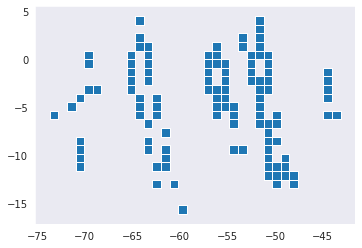

In [ ]:
mapbiomas = pd.read_csv('/content/drive/MyDrive/oco-2_mapbiomas inverno-2015a2021/oco2-mapbiomas-inverno-Grid_Amazonia_Legal_100km.csv')
mapbiomas.index
mapbiomas['geometry'] = formatted_geometry(mapbiomas['.geo'])
mapbiomas_geo = gpd.GeoDataFrame(mapbiomas)
mapbiomas_geo = mapbiomas_geo.set_crs('EPSG:4674')
mapbiomas_geo = mapbiomas_geo.drop(columns=['.geo'])
mapbiomas_geo['system_ind'] = mapbiomas_geo['system:index']

# # data_types_dict = {'index': int}
# # geodf_oco2 = geodf_oco2.astype(data_types_dict)

oco2_classes = pd.merge(geodf_oco2,mapbiomas_geo,'inner','system_ind')

print(oco2_classes.shape)
print(mapbiomas_geo.shape)

oco2_classes['geometry'] = oco2_classes['geometry_x']
#oco2_classes = oco2_classes.set_crs('EPSG:4674')
oco2_classes = oco2_classes.dropna()
oco2_classes.plot()

In [ ]:
oco2_classes['classification_2020'] = oco2_classes['classification_2020'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })

In [ ]:
oco2_classes['classification_2015'] = oco2_classes['classification_2015'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })
oco2_classes['classification_2016'] = oco2_classes['classification_2016'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })
oco2_classes['classification_2017'] = oco2_classes['classification_2017'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })
oco2_classes['classification_2018'] = oco2_classes['classification_2018'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })
oco2_classes['classification_2019'] = oco2_classes['classification_2019'].map( {3.0: 'Formação Florestal', 4.0: 'Formação Savânica', 12.0: 'Formação Campestre', 15.0: 'Pastagem', 39.0: 'Soja', 5.0: 'Mangue', 33.0: "Rio, Lago e Oceano", 21.0: "Mosaico de Agricultura e Pastagem", 32.0: "Apicum", 11.0: "Campo Alagado e Área Pantanosa", 24.0: "Área Urbana", 9.0: 'Silvicultura', 41.0: 'Outras Lavrouras temporárias', 25.0: 'Outras áreas não vegetadas', 48.0: 'Outras Lavrouras Perenes', 20.0: "Cana", 30: 'Mineração', 23: "Praia, Duna e Areal" })

In [ ]:
oco2_classes['classification_2020'].unique()

array(['Pastagem', 'Campo Alagado e Área Pantanosa', 'Formação Florestal',
       'Formação Savânica', 'Formação Campestre', 'Mangue'], dtype=object)

/usr/local/lib/python3.8/dist-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.8/dist-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/usr/local/lib/python3.8/dist-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/usr/local/lib/python3.8/dist-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


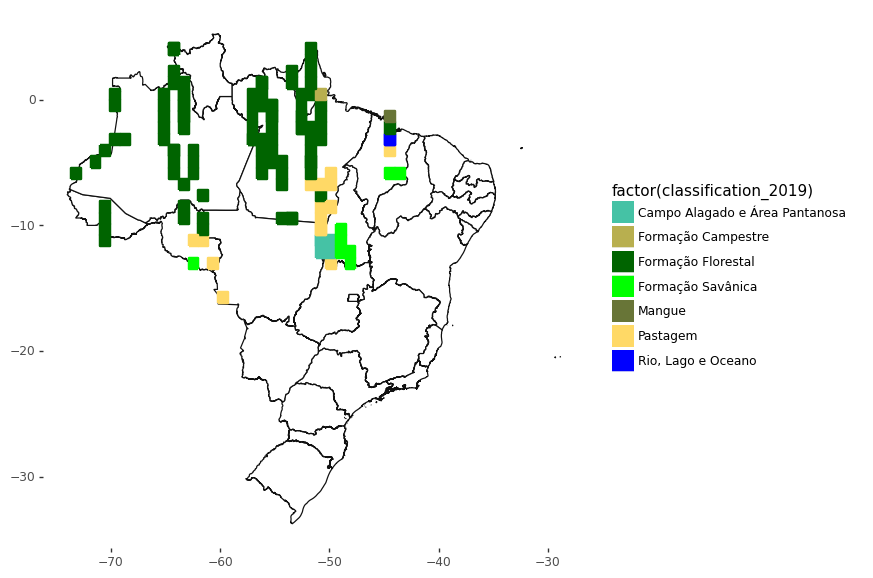

<ggplot: (8737468704618)>

In [ ]:
(
    ggplot() 
    + geom_map(geo_ufs, fill ='white')
    + geom_map(oco2_classes, aes(fill='factor(classification_2019)', color='factor(classification_2019)'), size=1)
    + geom_point()
    + scale_color_manual(values=classPaletteSt)
    + scale_fill_manual(values=classPaletteSt)
    + theme(figure_size=(7, 7), panel_background=element_rect(fill='white'))
)

/usr/local/lib/python3.8/dist-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


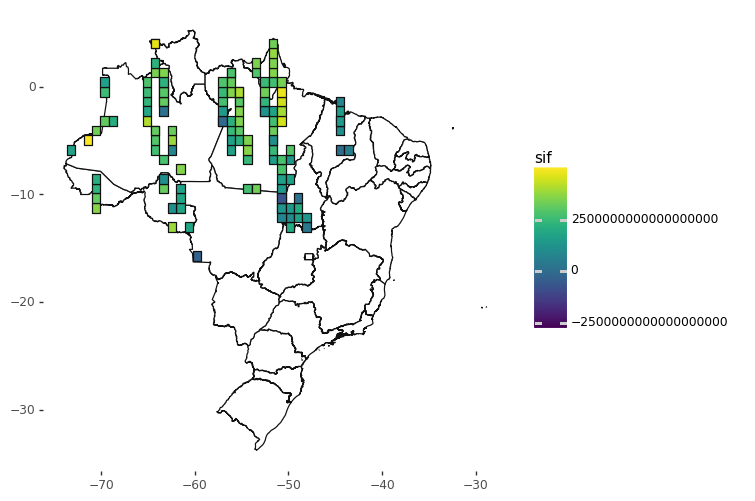

<ggplot: (8737468073903)>

In [ ]:
(
    ggplot() 
    + geom_map(geo_ufs, fill ='white')
    + geom_map(oco2_classes, aes(fill='sif'))
    + theme(figure_size=(6, 6), panel_background=element_rect(fill='white'))
)

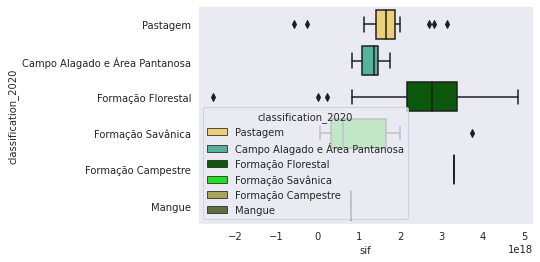

In [ ]:
sns.boxplot(data=oco2_classes, x="sif", y="classification_2020",hue='classification_2020',dodge=False,palette=classPaletteSt)

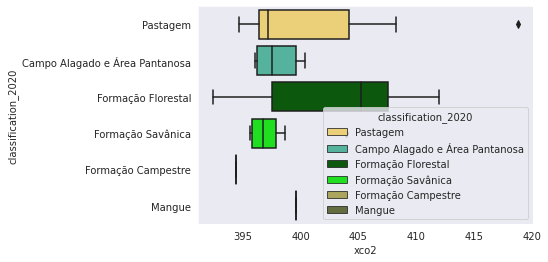

In [ ]:
sns.boxplot(data=oco2_classes, x="xco2", y="classification_2020",hue='classification_2020',dodge=False,palette=classPaletteSt)

/usr/local/lib/python3.8/dist-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.8/dist-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/usr/local/lib/python3.8/dist-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/usr/local/lib/python3.8/dist-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


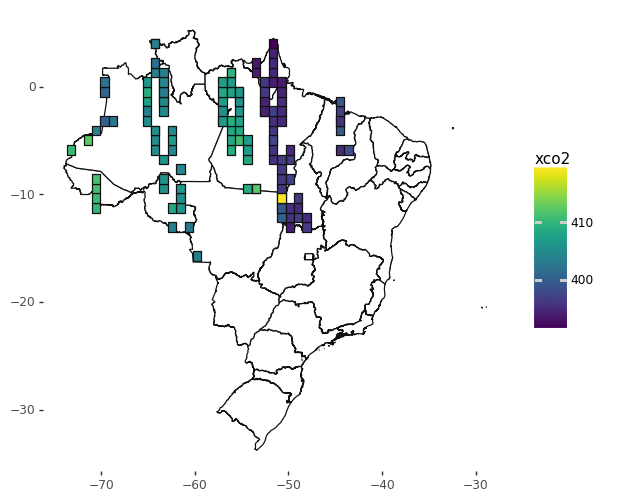

<ggplot: (8737466341099)>

In [ ]:
(
    ggplot() 
    + geom_map(geo_ufs, fill ='white')
    + geom_map(oco2_classes, aes(fill='xco2'))
    + theme(figure_size=(6, 6), panel_background=element_rect(fill='white'))
)

In [ ]:
oco2_classes = oco2_classes.drop(columns=['system:index',
       'classification_1985', 'classification_1986', 'classification_1987',
       'classification_1988', 'classification_1989', 'classification_1990',
       'classification_1991', 'classification_1992', 'classification_1993',
       'classification_1994', 'classification_1995', 'classification_1996',
       'classification_1997', 'classification_1998', 'classification_1999',
       'classification_2000', 'classification_2001', 'classification_2002',
       'classification_2003', 'classification_2004', 'classification_2005',
       'classification_2006', 'classification_2007', 'classification_2008',
       'classification_2009', 'classification_2010', 'classification_2011',
       'classification_2012', 'classification_2013', 'classification_2014','geometry_y','geometry_x'])

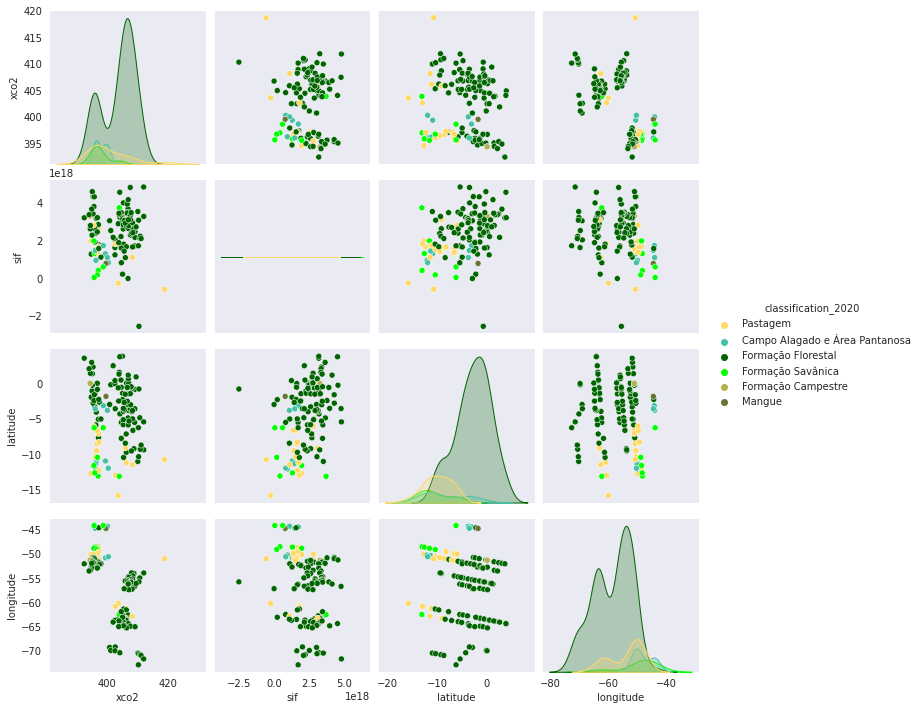

In [ ]:
sns.pairplot(oco2_classes, hue='classification_2020', palette=classPaletteSt, vars=['xco2','sif','latitude','longitude'])

###Valores negativos de SIF

In [ ]:
negative_sif = oco2_classes[oco2_classes.sif < 0]
negative_sif_productivity = negative_sif[negative_sif.sif > -1]
negative_sif_retrieval_error = negative_sif[(negative_sif.sif < -1) ]
print('negative_sif',negative_sif_productivity.shape)
print('negative_sif_retrieval_error',negative_sif_retrieval_error.shape)

negative_sif (0, 34)
negative_sif_retrieval_error (4, 34)


In [ ]:
negative_sif_retrieval_error

,Unnamed: 0,system_ind,DayOfYear,DetailedQA,EVI,NDVI,RelativeAz,SolarZenit,SummaryQA,ViewZenith,...,datetime,day_date,day_time,classification_2015,classification_2016,classification_2017,classification_2018,classification_2019,classification_2020,geometry
6,126,00000000000000000093,284.890411,2185.000000,3819.410959,6171.534247,-8015.630137,2299.260274,1.000000,1695.561644,...,2021-09-30 16:57:09.780,2021-09-30,16:57:09.780000,Pastagem,Pastagem,Pastagem,Pastagem,Pastagem,Pastagem,"POLYGON ((-51.20397 -10.77978, -51.20397 -9.88..."
57,56,00000000000000000013,235.057143,2116.000000,2755.722449,5229.077551,-4014.946939,3666.685714,0.000000,1800.600000,...,2018-08-13 17:45:57.740,2018-08-13,17:45:57.740000,Formação Savânica,Formação Savânica,Pastagem,Formação Savânica,Pastagem,Pastagem,"POLYGON ((-60.18712 -16.16968, -60.18712 -15.2..."
96,113,00000000000000000191,261.602362,3333.511811,5086.826772,8059.389764,-7065.452756,2238.429134,0.000000,3655.153543,...,2019-09-14 17:18:13.380,2019-09-14,17:18:13.380000,Formação Florestal,Formação Florestal,Formação Florestal,Formação Florestal,Formação Florestal,Formação Florestal,"POLYGON ((-57.49218 -3.59326, -57.49218 -2.694..."
115,110,000000000000000001ec,253.901575,2125.854331,5729.602362,8368.562992,-1214.704724,2418.385827,0.224409,2710.381890,...,2019-08-29 17:19:02.720,2019-08-29,17:19:02.720000,Formação Florestal,Formação Florestal,Formação Florestal,Formação Florestal,Formação Florestal,Formação Florestal,"POLYGON ((-55.69555 -0.89832, -55.69555 -0.000..."


### Células que obteve mudança de uso do solo de 2015 a 2021

In [ ]:
dict_change_classes = {}
for row, col in oco2_classes.iterrows():
  # if 'classification' in col:
  if (col['classification_2015'] != col['classification_2016']) or (col['classification_2015'] != col['classification_2017']) or (col['classification_2015'] != col['classification_2018']) or (col['classification_2015'] != col['classification_2019']) or (col['classification_2015'] != col['classification_2020']):
   dict_change_classes[col['system_ind']] = [col['classification_2015'],col['classification_2016'], col['classification_2017'], col['classification_2018'],col['classification_2019'],col['classification_2020']]

In [ ]:
print(len(dict_change_classes.keys()))
print(dict_change_classes)

6
{'0000000000000000005d': ['Pastagem', 'Pastagem', 'Pastagem', 'Formação Savânica', 'Formação Savânica', 'Pastagem'], '00000000000000000139': ['Formação Florestal', 'Pastagem', 'Pastagem', 'Pastagem', 'Pastagem', 'Pastagem'], '00000000000000000181': ['Pastagem', 'Campo Alagado e Área Pantanosa', 'Campo Alagado e Área Pantanosa', 'Campo Alagado e Área Pantanosa', 'Pastagem', 'Campo Alagado e Área Pantanosa'], '0000000000000000019f': ['Rio, Lago e Oceano', 'Campo Alagado e Área Pantanosa', 'Campo Alagado e Área Pantanosa', 'Campo Alagado e Área Pantanosa', 'Rio, Lago e Oceano', 'Campo Alagado e Área Pantanosa'], '00000000000000000013': ['Formação Savânica', 'Formação Savânica', 'Pastagem', 'Formação Savânica', 'Pastagem', 'Pastagem'], '000000000000000000a5': ['Formação Florestal', 'Formação Florestal', 'Formação Florestal', 'Formação Florestal', 'Formação Florestal', 'Pastagem']}


In [ ]:
changed = list(dict_change_classes.keys())
mask = oco2_classes['system_ind'].isin(changed)
oco2_changed_class = oco2_classes.loc[mask]
oco2_changed_class.head(3)

,Unnamed: 0,system_ind,DayOfYear,DetailedQA,EVI,NDVI,RelativeAz,SolarZenit,SummaryQA,ViewZenith,...,datetime,day_date,day_time,classification_2015,classification_2016,classification_2017,classification_2018,classification_2019,classification_2020,geometry
24,19,0000000000000000005d,254.000000,2156.342742,2522.524194,4347.241935,-5030.750000,2970.366935,0.584677,644.016129,...,2015-08-29 16:57:20.700,2015-08-29,16:57:20.700000,Pastagem,Pastagem,Pastagem,Formação Savânica,Formação Savânica,Pastagem,"POLYGON ((-49.40734 -12.57641, -49.40734 -11.6..."
30,25,00000000000000000139,249.753968,2179.293651,4011.956349,6308.007937,-8734.317460,2596.400794,0.436508,1421.408730,...,2015-08-29 16:59:04.760,2015-08-29,16:59:04.760000,Formação Florestal,Pastagem,Pastagem,Pastagem,Pastagem,Pastagem,"POLYGON ((-50.30566 -6.28821, -50.30566 -5.389..."
45,44,00000000000000000181,245.395257,2136.553360,3600.754941,5929.569170,-5225.754941,2612.695652,0.079051,2029.138340,...,2016-08-28 16:27:42.040,2016-08-28,16:27:42.040000,Pastagem,Campo Alagado e Área Pantanosa,Campo Alagado e Área Pantanosa,Campo Alagado e Área Pantanosa,Pastagem,Campo Alagado e Área Pantanosa,"POLYGON ((-44.91576 -3.59326, -44.80347 -3.593..."


In [ ]:
mask = oco2_classes['system_ind'].isin(changed)

In [ ]:
oco2_changed_class = oco2_classes.loc[mask]
print(oco2_changed_class.shape)

(7, 34)


In [ ]:
oco2_changed_class.head(3)

,Unnamed: 0,system_ind,DayOfYear,DetailedQA,EVI,NDVI,RelativeAz,SolarZenit,SummaryQA,ViewZenith,...,datetime,day_date,day_time,classification_2015,classification_2016,classification_2017,classification_2018,classification_2019,classification_2020,geometry
24,19,0000000000000000005d,254.000000,2156.342742,2522.524194,4347.241935,-5030.750000,2970.366935,0.584677,644.016129,...,2015-08-29 16:57:20.700,2015-08-29,16:57:20.700000,Pastagem,Pastagem,Pastagem,Formação Savânica,Formação Savânica,Pastagem,"POLYGON ((-49.40734 -12.57641, -49.40734 -11.6..."
30,25,00000000000000000139,249.753968,2179.293651,4011.956349,6308.007937,-8734.317460,2596.400794,0.436508,1421.408730,...,2015-08-29 16:59:04.760,2015-08-29,16:59:04.760000,Formação Florestal,Pastagem,Pastagem,Pastagem,Pastagem,Pastagem,"POLYGON ((-50.30566 -6.28821, -50.30566 -5.389..."
45,44,00000000000000000181,245.395257,2136.553360,3600.754941,5929.569170,-5225.754941,2612.695652,0.079051,2029.138340,...,2016-08-28 16:27:42.040,2016-08-28,16:27:42.040000,Pastagem,Campo Alagado e Área Pantanosa,Campo Alagado e Área Pantanosa,Campo Alagado e Área Pantanosa,Pastagem,Campo Alagado e Área Pantanosa,"POLYGON ((-44.91576 -3.59326, -44.80347 -3.593..."


In [ ]:
oco2_changed_class.to_csv('/content/drive/MyDrive/oco-2-standard/eda/amostras-mudanças-uso-do-solo-2015-2021-ago-set-100km-evi.csv')

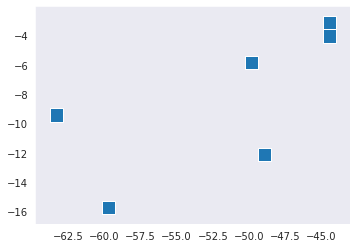

In [ ]:
oco2_changed_class.plot()

### Células colocalizadas

In [ ]:
index_unique = oco2_classes['system_ind'].unique()
index_unique.shape

(110,)

In [ ]:
dict_colocated = {}
# for row, col in oco2_classes.iterrows():
for id in index_unique:
  dict_colocated[id] = oco2_classes[oco2_classes['system_ind'] == id]

In [ ]:
dict_colocated.keys()

dict_keys(['00000000000000000046', '0000000000000000005c', '00000000000000000075', '00000000000000000076', '00000000000000000093', '000000000000000000b3', '000000000000000000d3', '000000000000000000f4', '00000000000000000115', '00000000000000000116', '00000000000000000137', '00000000000000000159', '00000000000000000179', '00000000000000000197', '000000000000000001b4', '000000000000000001b5', '000000000000000001d2', '0000000000000000020a', '00000000000000000048', '0000000000000000005d', '0000000000000000005e', '00000000000000000077', '00000000000000000095', '000000000000000000d4', '00000000000000000117', '00000000000000000139', '00000000000000000198', '000000000000000001b6', '000000000000000001d4', '000000000000000001f1', '0000000000000000020b', '0000000000000000020c', '00000000000000000223', '00000000000000000237', '00000000000000000241', '0000000000000000024a', '0000000000000000005b', '000000000000000001ef', '00000000000000000221', '00000000000000000235', '00000000000000000181', '0000

In [ ]:
dict_colocated.keys()

dict_keys(['00000000000000000046', '0000000000000000005c', '00000000000000000075', '00000000000000000076', '00000000000000000093', '000000000000000000b3', '000000000000000000d3', '000000000000000000f4', '00000000000000000115', '00000000000000000116', '00000000000000000137', '00000000000000000159', '00000000000000000179', '00000000000000000197', '000000000000000001b4', '000000000000000001b5', '000000000000000001d2', '0000000000000000020a', '00000000000000000048', '0000000000000000005d', '0000000000000000005e', '00000000000000000077', '00000000000000000095', '000000000000000000d4', '00000000000000000117', '00000000000000000139', '00000000000000000198', '000000000000000001b6', '000000000000000001d4', '000000000000000001f1', '0000000000000000020b', '0000000000000000020c', '00000000000000000223', '00000000000000000237', '00000000000000000241', '0000000000000000024a', '0000000000000000005b', '000000000000000001ef', '00000000000000000221', '00000000000000000235', '00000000000000000181', '0000

## a. Cálculo da quantidade de amostras totais, para cada classe, para cada região e para cada classe por região.


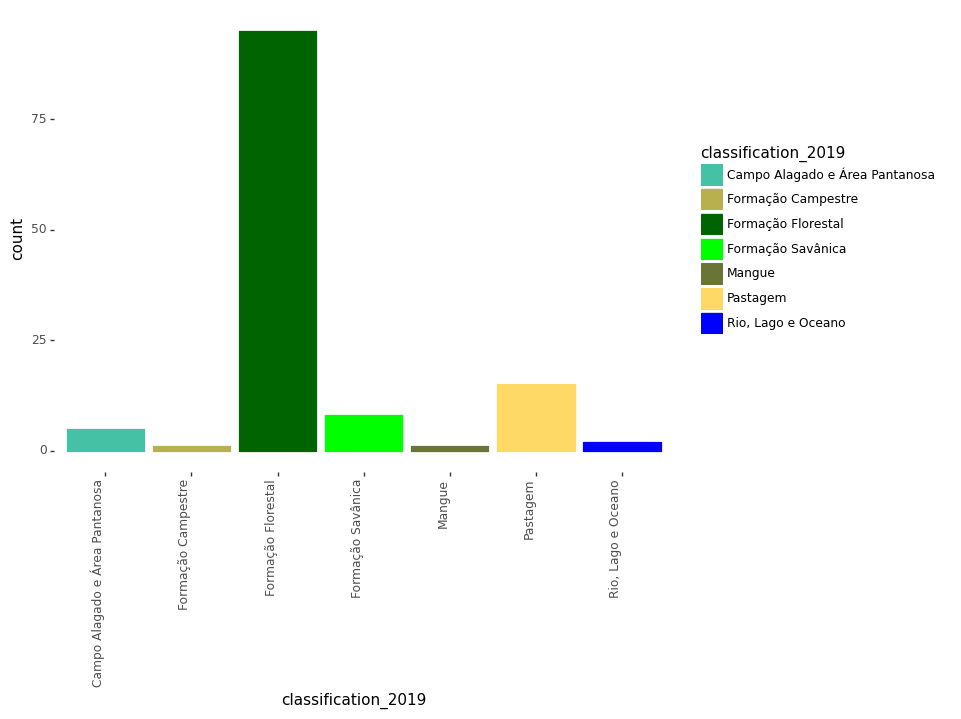

<ggplot: (8737463716753)>

In [ ]:
(
    ggplot(oco2_classes) 
    + aes(x='classification_2019', fill='classification_2019', color='classification_2019') 
    + geom_bar()
    + scale_color_manual(values=classPaletteSt)
    + scale_fill_manual(values=classPaletteSt)
    + theme(axis_text_x=element_text(rotation=90, hjust=1))
    + theme(figure_size=(8, 6), panel_background=element_rect(fill='white'))
)

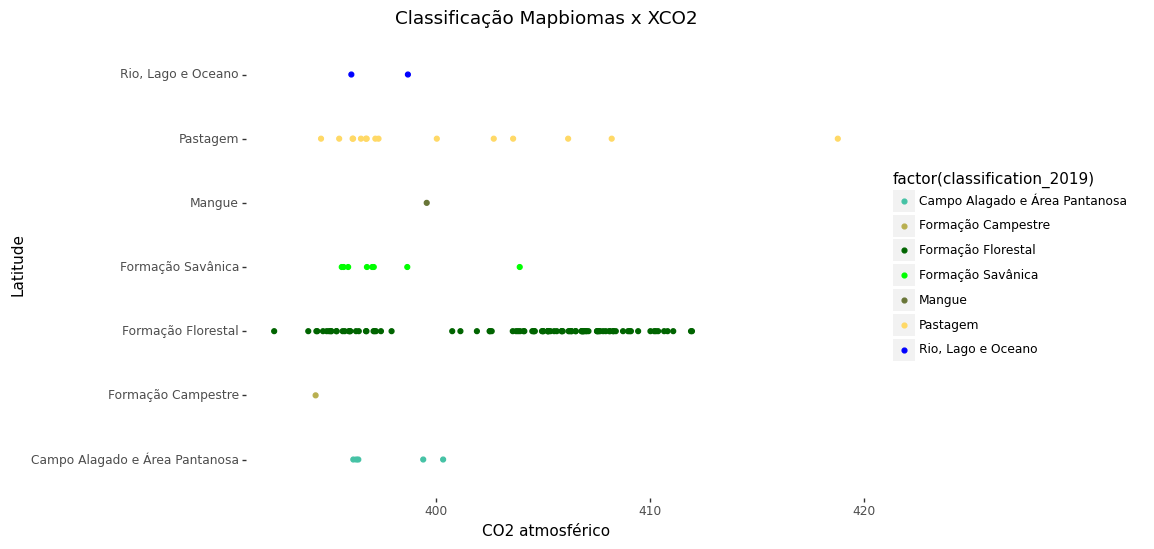

<ggplot: (8737463661686)>

In [ ]:
(ggplot(oco2_classes)
 + aes(x='xco2', y='classification_2019', color='factor(classification_2019)')
 + geom_point()
 + scale_color_manual(values=classPaletteSt)
 + scale_y_discrete()
 + labs(title='Classificação Mapbiomas x XCO2', x='CO2 atmosférico', y='Latitude')
 + theme(figure_size=(8, 6), panel_background=element_rect(fill='white'))
)

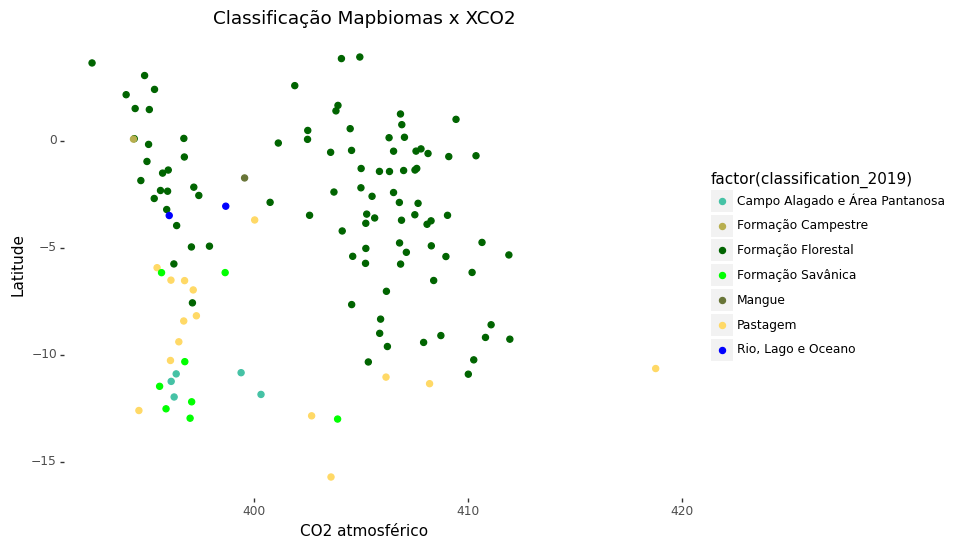

<ggplot: (8737463720596)>

In [ ]:
(ggplot(oco2_classes)
 + aes(x='xco2', y='latitude', color='factor(classification_2019)')
 + geom_point(size=2)
 + scale_color_manual(values=classPaletteSt)
 + labs(title='Classificação Mapbiomas x XCO2', x='CO2 atmosférico', y='Latitude')
 + theme(figure_size=(8, 6), panel_background=element_rect(fill='white'))
)

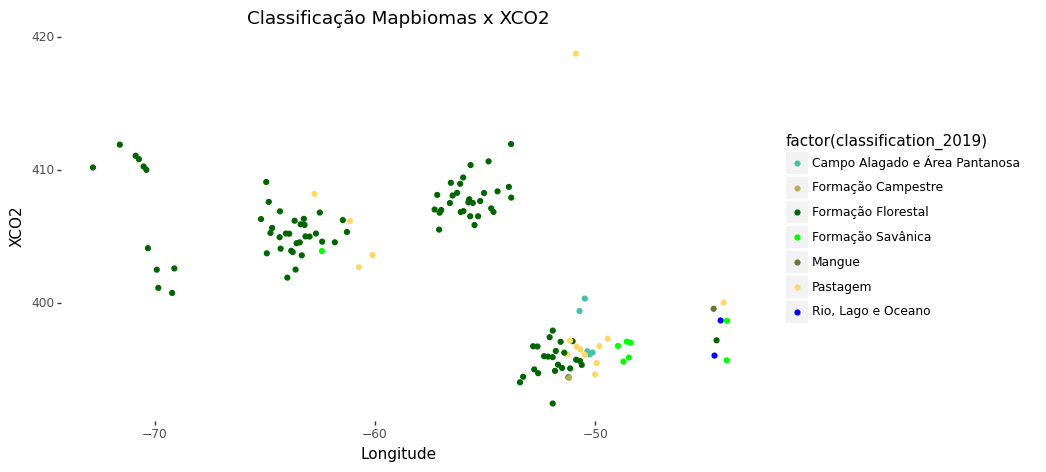

<ggplot: (8737463660680)>

In [ ]:
(ggplot(oco2_classes)
 + aes(x='longitude', y='xco2', color='factor(classification_2019)')
 + geom_point()
 + scale_color_manual(values=classPaletteSt)
 + labs(title='Classificação Mapbiomas x XCO2', x='Longitude', y='XCO2')
 + theme(figure_size=(9, 5), panel_background=element_rect(fill='white'))
)

In [ ]:
oco2_classes.columns

Index(['Unnamed: 0', 'system_ind', 'DayOfYear', 'DetailedQA', 'EVI', 'NDVI',
       'RelativeAz', 'SolarZenit', 'SummaryQA', 'ViewZenith', 'sur_refl_b',
       'sur_refl_1', 'sur_refl_2', 'sur_refl_3', 'xco2', 'xco2_uncer', 'sif',
       'sif_unc', 'out_flag', 'sound_id', 'latitude', 'longitude',
       'land_w_ind', 'land_frac', 'datetime', 'day_date', 'day_time',
       'classification_2015', 'classification_2016', 'classification_2017',
       'classification_2018', 'classification_2019', 'classification_2020',
       'geometry'],
      dtype='object')

In [ ]:
oco2_classes.classification_2020.unique()

array(['Pastagem', 'Campo Alagado e Área Pantanosa', 'Formação Florestal',
       'Formação Savânica', 'Formação Campestre', 'Mangue'], dtype=object)

In [ ]:
florestal = oco2_classes[oco2_classes.classification_2020 == 'Formação Florestal']
pastagem = oco2_classes[oco2_classes.classification_2020 == 'Pastagem']
campestre = oco2_classes[oco2_classes.classification_2020 == 'Formação Campestre']
savanica = oco2_classes[oco2_classes.classification_2020 == 'Formação Savânica']
rio = oco2_classes[oco2_classes.classification_2020 == 'Rio, Lago e Oceano']
alagado_pantanosa = oco2_classes[oco2_classes.classification_2020 == 'Campo Alagado e Área Pantanosa']
mangue = oco2_classes[oco2_classes.classification_2020 == 'Mangue']
# soja = oco2_classes[oco2_classes.classification_2020 == 'Soja']

####Formação Florestal

In [ ]:
florestal.describe()

,Unnamed: 0,DayOfYear,DetailedQA,EVI,NDVI,RelativeAz,SolarZenit,SummaryQA,ViewZenith,sur_refl_b,...,xco2,xco2_uncer,sif,sif_unc,out_flag,sound_id,latitude,longitude,land_w_ind,land_frac
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,...,94.000000,94.000000,9.400000e+01,9.400000e+01,94.0,9.400000e+01,94.000000,94.000000,94.000000,94.000000
mean,73.276596,250.175279,3323.679434,5078.101564,7995.317117,-4584.019832,2473.644554,0.504695,2221.858957,347.256925,...,403.710901,0.623132,2.678743e+18,4.783973e+17,1.0,2.017639e+15,-2.771315,-58.767898,0.048591,97.844420
std,34.063636,16.061248,3046.694830,493.982492,564.622861,4320.824362,385.566140,0.652386,863.485198,113.716638,...,5.324178,0.076041,1.083984e+18,6.774894e+16,0.0,1.707710e+12,3.502311,6.460587,0.315998,11.336847
min,7.000000,225.466403,2078.600791,3623.466403,5681.916996,-13854.146245,1716.207843,0.000000,620.932000,187.166008,...,392.456400,0.451357,-2.525493e+18,-9.999990e+05,1.0,2.015081e+15,-10.918157,-72.808630,0.000000,8.333333
25%,43.750000,235.373430,2119.549784,4787.558912,7755.859520,-8225.042914,2112.103755,0.000000,1483.917179,273.818148,...,397.565204,0.562083,2.148886e+18,4.607291e+17,1.0,2.015339e+15,-4.963795,-63.786395,0.000000,100.000000
50%,78.500000,250.334085,2260.264634,5157.679304,8160.370000,-4519.103211,2437.236067,0.201192,2305.240157,317.515733,...,405.258167,0.621166,2.771002e+18,4.871693e+17,1.0,2.018087e+15,-2.417567,-56.512869,0.000000,100.000000
75%,101.750000,261.627863,3333.641732,5465.882457,8367.738450,-1236.785433,2772.299883,0.877103,2756.466563,385.401372,...,407.567856,0.689400,3.357920e+18,5.139348e+17,1.0,2.019083e+15,-0.408088,-53.306223,0.000000,100.000000
max,125.000000,285.537549,23837.067194,6094.276680,8760.681102,5869.347826,3370.880734,2.755906,4206.011765,937.300000,...,411.960570,0.786350,4.835881e+18,6.073293e+17,1.0,2.020093e+15,3.902825,-44.486206,3.000000,100.000000


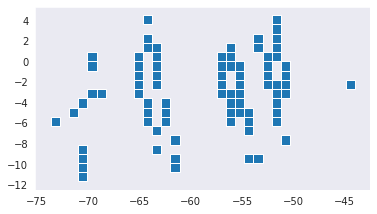

In [ ]:
florestal.plot()

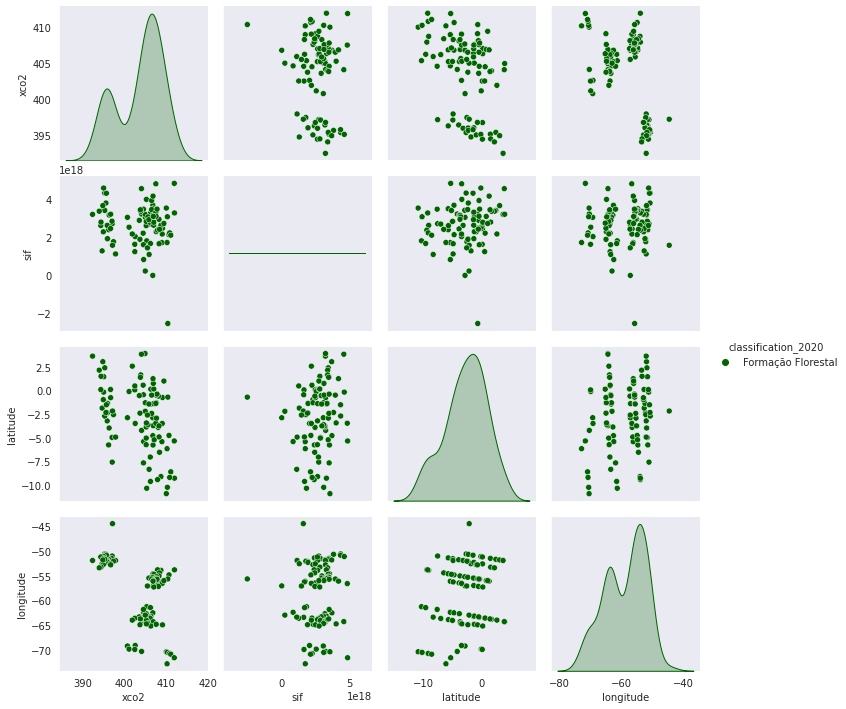

In [ ]:
sns.pairplot(florestal, hue='classification_2020', palette=classPaletteSt, vars=['xco2','sif','latitude','longitude'])

####Pastagem

In [ ]:
pastagem.describe()

,Unnamed: 0,DayOfYear,DetailedQA,EVI,NDVI,RelativeAz,SolarZenit,SummaryQA,ViewZenith,sur_refl_b,...,xco2,xco2_uncer,sif,sif_unc,out_flag,sound_id,latitude,longitude,land_w_ind,land_frac
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,...,16.000000,16.000000,1.600000e+01,1.600000e+01,16.0,1.600000e+01,16.000000,16.000000,16.0,16.0
mean,34.937500,241.658789,2207.117035,3586.062030,5890.996580,-5372.345044,3092.220042,0.181074,1245.821665,742.673622,...,400.586957,0.569857,1.588002e+18,4.275993e+17,1.0,2.016395e+15,-9.861612,-53.805397,0.0,100.0
std,34.707288,14.806763,208.963687,580.495434,661.513105,4931.044241,385.497646,0.344011,458.496275,113.350091,...,6.547553,0.095844,9.539515e+17,4.461529e+16,0.0,1.889291e+12,2.738639,5.499767,0.0,0.0
min,0.000000,228.225296,2116.000000,2522.524194,4347.241935,-12449.563492,2299.260274,0.000000,551.304000,591.408730,...,394.644000,0.436320,-5.649042e+17,3.129904e+17,1.0,2.015081e+15,-15.723035,-63.198135,0.0,100.0
25%,7.500000,229.776786,2116.000000,3305.072662,5553.514509,-9030.508247,2902.131775,0.000000,888.408988,670.720027,...,396.415849,0.476857,1.414326e+18,4.167995e+17,1.0,2.015081e+15,-11.573187,-60.265027,0.0,100.0
50%,23.500000,237.387158,2116.000000,3652.220000,6102.731123,-6395.048913,3109.436079,0.000000,1274.307206,722.580102,...,397.143033,0.566982,1.647210e+18,4.286618e+17,1.0,2.015083e+15,-9.841023,-50.860167,0.0,100.0
75%,57.250000,248.271825,2177.156413,4043.081349,6338.751952,-877.780030,3383.489425,0.109127,1509.382443,753.792944,...,404.179775,0.663318,1.865024e+18,4.508568e+17,1.0,2.018081e+15,-7.887169,-49.983088,0.0,100.0
max,126.000000,284.890411,2867.483871,4404.500000,6640.619048,4071.788000,3666.685714,1.000000,1926.188000,1048.512097,...,418.768100,0.693985,3.126870e+18,4.980552e+17,1.0,2.021093e+15,-5.941711,-48.563075,0.0,100.0


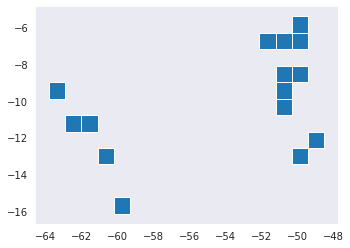

In [ ]:
pastagem.plot()

####Formação Savânica

In [ ]:
savanica.describe()

,Unnamed: 0,DayOfYear,DetailedQA,EVI,NDVI,RelativeAz,SolarZenit,SummaryQA,ViewZenith,sur_refl_b,...,xco2,xco2_uncer,sif,sif_unc,out_flag,sound_id,latitude,longitude,land_w_ind,land_frac
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,7.000000,7.000000,7.000000e+00,7.000000e+00,7.0,7.000000e+00,7.000000,7.000000,7.0,7.0
mean,36.285714,257.832939,2132.663110,3066.371064,5215.608469,-4673.115689,2754.985659,0.138910,1231.567535,844.631636,...,397.661655,0.608352,1.188784e+18,4.095969e+17,1.0,2.015800e+15,-10.384005,-49.283444,0.0,100.0
std,20.693914,15.800952,27.372623,834.400539,1139.640691,5051.814026,434.903563,0.341993,510.181344,210.026607,...,2.956901,0.095178,1.312011e+18,3.310904e+16,0.0,1.113564e+12,3.026301,6.185753,0.0,0.0
min,18.000000,245.000000,2116.000000,2470.540323,4360.012097,-10708.473684,2085.813492,0.000000,740.366935,375.838710,...,395.610733,0.489173,5.451882e+16,3.572181e+17,1.0,2.015083e+15,-13.014507,-62.407460,0.0,100.0
25%,20.500000,247.000000,2116.000000,2671.246861,4726.720459,-7897.404890,2519.554791,0.000000,901.555789,880.549081,...,395.805280,0.538920,3.085384e+17,4.014946e+17,1.0,2.015083e+15,-12.755290,-48.838898,0.0,100.0
50%,22.000000,251.262097,2116.000000,2708.360000,4756.526316,-5912.701835,2903.120000,0.000000,1053.024194,910.944444,...,396.786682,0.576629,6.123480e+17,4.064779e+17,1.0,2.015083e+15,-11.485216,-48.473484,0.0,100.0
75%,52.500000,266.950907,2142.827765,3025.194444,5103.446429,-2083.984841,3027.016978,0.029762,1399.276686,939.330550,...,397.852004,0.692854,1.651339e+18,4.156564e+17,1.0,2.016093e+15,-8.253273,-46.207516,0.0,100.0
max,68.000000,280.666667,2178.986239,4892.814516,7732.387097,3872.145161,3202.822581,0.912844,2225.916667,985.879032,...,403.919600,0.729113,3.734866e+18,4.691801e+17,1.0,2.018083e+15,-6.171188,-44.010334,0.0,100.0


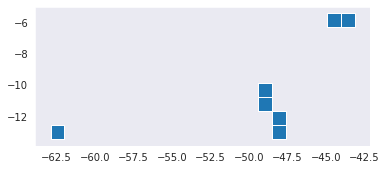

In [ ]:
savanica.plot()

####Formação Campestre

In [ ]:
campestre.describe()

,Unnamed: 0,DayOfYear,DetailedQA,EVI,NDVI,RelativeAz,SolarZenit,SummaryQA,ViewZenith,sur_refl_b,...,xco2,xco2_uncer,sif,sif_unc,out_flag,sound_id,latitude,longitude,land_w_ind,land_frac
count,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.0000,1.000000e+00,1.000000e+00,1.0,1.000000e+00,1.000000,1.000000,1.0,1.0
mean,31.0,245.929134,2241.496063,4626.385827,6993.901575,-3053.507874,2356.905512,0.314961,2103.389764,557.570866,...,394.390995,0.5057,3.298866e+18,4.682513e+17,1.0,2.015083e+15,0.066084,-51.185162,0.0,100.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,31.0,245.929134,2241.496063,4626.385827,6993.901575,-3053.507874,2356.905512,0.314961,2103.389764,557.570866,...,394.390995,0.5057,3.298866e+18,4.682513e+17,1.0,2.015083e+15,0.066084,-51.185162,0.0,100.0
25%,31.0,245.929134,2241.496063,4626.385827,6993.901575,-3053.507874,2356.905512,0.314961,2103.389764,557.570866,...,394.390995,0.5057,3.298866e+18,4.682513e+17,1.0,2.015083e+15,0.066084,-51.185162,0.0,100.0
50%,31.0,245.929134,2241.496063,4626.385827,6993.901575,-3053.507874,2356.905512,0.314961,2103.389764,557.570866,...,394.390995,0.5057,3.298866e+18,4.682513e+17,1.0,2.015083e+15,0.066084,-51.185162,0.0,100.0
75%,31.0,245.929134,2241.496063,4626.385827,6993.901575,-3053.507874,2356.905512,0.314961,2103.389764,557.570866,...,394.390995,0.5057,3.298866e+18,4.682513e+17,1.0,2.015083e+15,0.066084,-51.185162,0.0,100.0
max,31.0,245.929134,2241.496063,4626.385827,6993.901575,-3053.507874,2356.905512,0.314961,2103.389764,557.570866,...,394.390995,0.5057,3.298866e+18,4.682513e+17,1.0,2.015083e+15,0.066084,-51.185162,0.0,100.0


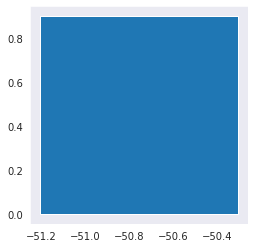

In [ ]:
campestre.plot()

####Rio, Lago e Oceano

In [ ]:
rio.describe()

,Unnamed: 0,DayOfYear,DetailedQA,EVI,NDVI,RelativeAz,SolarZenit,SummaryQA,ViewZenith,sur_refl_b,...,xco2,xco2_uncer,sif,sif_unc,out_flag,sound_id,latitude,longitude,land_w_ind,land_frac
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
rio.plot()

/usr/local/lib/python3.8/dist-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f25c973ee50> (for post_execute):


ValueError: ignored

ValueError: ignored

####Campo Alagado e Área Pantanosa

In [ ]:
alagado_pantanosa.describe()

,Unnamed: 0,DayOfYear,DetailedQA,EVI,NDVI,RelativeAz,SolarZenit,SummaryQA,ViewZenith,sur_refl_b,...,xco2,xco2_uncer,sif,sif_unc,out_flag,sound_id,latitude,longitude,land_w_ind,land_frac
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,8.000000,8.000000,8.000000e+00,8.000000e+00,8.0,8.000000e+00,8.000000,8.000000,8.0,8.0
mean,27.750000,247.691806,2255.171040,3256.193135,5591.107118,-5172.384632,2870.798935,0.130452,1503.665222,744.222108,...,397.923752,0.605449,1.285726e+18,4.036210e+17,1.0,2.015461e+15,-8.392327,-48.118461,0.0,100.0
std,22.024337,18.090380,251.553795,390.721585,452.689785,4407.778230,473.339161,0.252148,806.914596,171.565928,...,1.884528,0.122356,2.987583e+17,3.223292e+16,0.0,5.180031e+11,4.133833,3.129009,0.0,0.0
min,1.000000,229.000000,2116.000000,2754.383065,5031.229839,-11804.887550,2284.425197,0.000000,792.397590,535.943775,...,396.059427,0.480796,8.388729e+17,3.635570e+17,1.0,2.015081e+15,-11.983137,-50.707924,0.0,100.0
25%,2.750000,229.789274,2116.000000,2870.320192,5204.837368,-8391.013554,2578.600143,0.000000,896.092888,602.872972,...,396.254226,0.494851,1.071282e+18,3.776432e+17,1.0,2.015081e+15,-11.406828,-50.381128,0.0,100.0
50%,36.500000,246.437786,2116.000000,3367.166787,5579.997850,-4137.060938,2648.918692,0.000000,1073.812500,774.263619,...,397.541658,0.587048,1.348864e+18,3.986046e+17,1.0,2.015091e+15,-10.875983,-50.186776,0.0,100.0
75%,44.250000,261.000000,2264.666988,3589.706452,5957.905793,-2378.527323,3404.663815,0.121296,2164.153952,800.529924,...,399.573310,0.677030,1.462020e+18,4.301335e+17,1.0,2.016083e+15,-3.660087,-44.509928,0.0,100.0
max,54.000000,278.259843,2675.807087,3668.043307,6234.660000,235.433071,3452.794355,0.716535,2726.492126,1069.196850,...,400.344120,0.813597,1.742054e+18,4.506065e+17,1.0,2.016093e+15,-3.068335,-44.162966,0.0,100.0


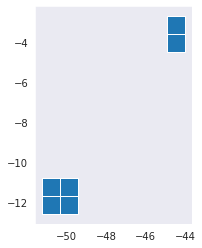

In [ ]:
alagado_pantanosa.plot()

####Mangue

In [ ]:
mangue.describe()

,Unnamed: 0,DayOfYear,DetailedQA,EVI,NDVI,RelativeAz,SolarZenit,SummaryQA,ViewZenith,sur_refl_b,...,xco2,xco2_uncer,sif,sif_unc,out_flag,sound_id,latitude,longitude,land_w_ind,land_frac
count,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.00000,1.000000,1.000000e+00,1.000000e+00,1.0,1.000000e+00,1.000000,1.000000,1.0,1.0
mean,47.0,243.0,46574.114625,3647.627273,5356.727273,-1701.381818,2454.536364,1.0,1780.090909,962.309091,...,399.57755,0.537192,7.969048e+17,4.530680e+17,1.0,2.016083e+15,-1.748197,-44.618105,1.5,92.5
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,47.0,243.0,46574.114625,3647.627273,5356.727273,-1701.381818,2454.536364,1.0,1780.090909,962.309091,...,399.57755,0.537192,7.969048e+17,4.530680e+17,1.0,2.016083e+15,-1.748197,-44.618105,1.5,92.5
25%,47.0,243.0,46574.114625,3647.627273,5356.727273,-1701.381818,2454.536364,1.0,1780.090909,962.309091,...,399.57755,0.537192,7.969048e+17,4.530680e+17,1.0,2.016083e+15,-1.748197,-44.618105,1.5,92.5
50%,47.0,243.0,46574.114625,3647.627273,5356.727273,-1701.381818,2454.536364,1.0,1780.090909,962.309091,...,399.57755,0.537192,7.969048e+17,4.530680e+17,1.0,2.016083e+15,-1.748197,-44.618105,1.5,92.5
75%,47.0,243.0,46574.114625,3647.627273,5356.727273,-1701.381818,2454.536364,1.0,1780.090909,962.309091,...,399.57755,0.537192,7.969048e+17,4.530680e+17,1.0,2.016083e+15,-1.748197,-44.618105,1.5,92.5
max,47.0,243.0,46574.114625,3647.627273,5356.727273,-1701.381818,2454.536364,1.0,1780.090909,962.309091,...,399.57755,0.537192,7.969048e+17,4.530680e+17,1.0,2.016083e+15,-1.748197,-44.618105,1.5,92.5


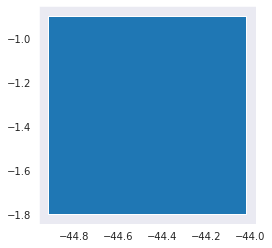

In [ ]:
mangue.plot()

#Resultado do agrupamento realizado pela rede SOM

In [ ]:
som5x5_result = pd.read_csv('/content/drive/MyDrive/resultados-oco2-som/5x5-100km-08-09-2015-2021.csv')

In [ ]:
from shapely import wkt
som5x5_result['geometry'] = som5x5_result['geometry'].apply(wkt.loads)
geosom5x5 = gpd.GeoDataFrame(som5x5_result,crs='EPSG:4674')
geosom5x5.set_geometry(col='geometry', inplace=True)

In [ ]:
list_clusters = geosom5x5['cluster_index'].unique()

/usr/local/lib/python3.8/dist-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.8/dist-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/usr/local/lib/python3.8/dist-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/usr/local/lib/python3.8/dist-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


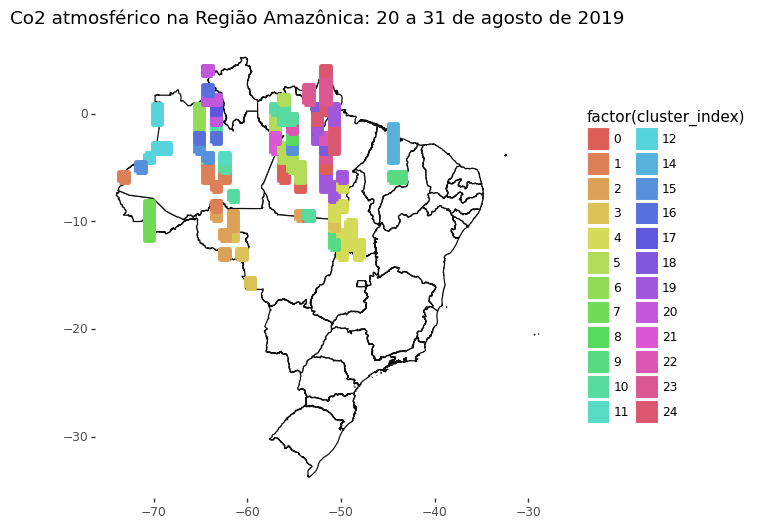

<ggplot: (8737463084538)>

In [ ]:
(
    ggplot() 
    + geom_map(geo_ufs, fill ='white')
    + geom_map(geosom5x5, aes(fill='factor(cluster_index)', color='factor(cluster_index)'), size=2)
    + geom_point()
    + labs(title='Co2 atmosférico na Região Amazônica: 20 a 31 de agosto de 2019 ')
    + theme(figure_size=(6, 6), panel_background=element_rect(fill='white'))
)

/usr/local/lib/python3.8/dist-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.8/dist-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/usr/local/lib/python3.8/dist-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/usr/local/lib/python3.8/dist-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


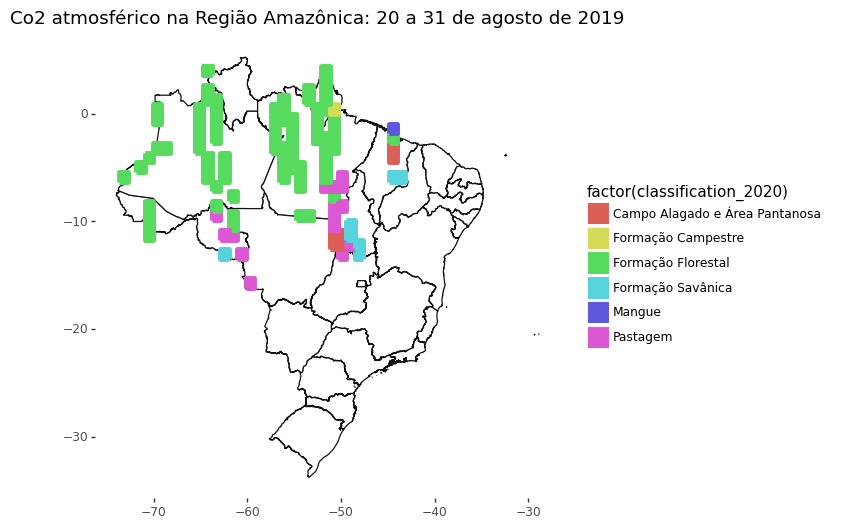

<ggplot: (8737463296564)>

In [ ]:
(
    ggplot() 
    + geom_map(geo_ufs, fill ='white')
    + geom_map(oco2_classes, aes(fill='factor(classification_2020)', color='factor(classification_2020)'), size=2)
    + geom_point()
    + labs(title='Co2 atmosférico na Região Amazônica: 20 a 31 de agosto de 2019 ')
    + theme(figure_size=(6, 6), panel_background=element_rect(fill='white'))
)

In [ ]:
for cluster in list_clusters:
  print(cluster, geosom5x5[geosom5x5.cluster_index == cluster].shape, geosom5x5[geosom5x5.cluster_index == cluster]['classification_2020'].unique())


4 (14, 51) ['Pastagem' 'Campo Alagado e Área Pantanosa' 'Formação Savânica']
9 (4, 51) ['Campo Alagado e Área Pantanosa' 'Formação Savânica']
3 (4, 51) ['Pastagem']
19 (9, 51) ['Formação Florestal' 'Pastagem' 'Formação Campestre']
23 (7, 51) ['Formação Florestal']
0 (6, 51) ['Formação Florestal']
18 (3, 51) ['Formação Florestal']
22 (3, 51) ['Formação Florestal']
24 (6, 51) ['Formação Florestal']
14 (5, 51) ['Campo Alagado e Área Pantanosa' 'Formação Florestal' 'Mangue']
12 (5, 51) ['Formação Florestal']
2 (6, 51) ['Formação Florestal' 'Formação Savânica' 'Pastagem']
1 (6, 51) ['Formação Florestal']
10 (11, 51) ['Formação Florestal']
11 (1, 51) ['Formação Florestal']
6 (5, 51) ['Formação Florestal']
17 (3, 51) ['Formação Florestal']
20 (5, 51) ['Formação Florestal']
15 (4, 51) ['Formação Florestal']
16 (3, 51) ['Formação Florestal']
5 (10, 51) ['Formação Florestal']
21 (2, 51) ['Formação Florestal']
8 (1, 51) ['Formação Florestal']
7 (4, 51) ['Formação Florestal']


In [ ]:
florestals = geosom5x5[geosom5x5.classification_2020 == 'Formação Florestal']
pastagems = geosom5x5[geosom5x5.classification_2020 == 'Pastagem']
campestres = geosom5x5[geosom5x5.classification_2020 == 'Formação Campestre']
savanicas = geosom5x5[geosom5x5.classification_2020 == 'Formação Savânica']
rios = geosom5x5[geosom5x5.classification_2020 == 'Rio, Lago e Oceano']
alagado_pantanosas = geosom5x5[geosom5x5.classification_2020 == 'Campo Alagado e Área Pantanosa']
mangues = geosom5x5[geosom5x5.classification_2020 == 'Mangue']
sojas = geosom5x5[geosom5x5.classification_2020 == 'Soja']

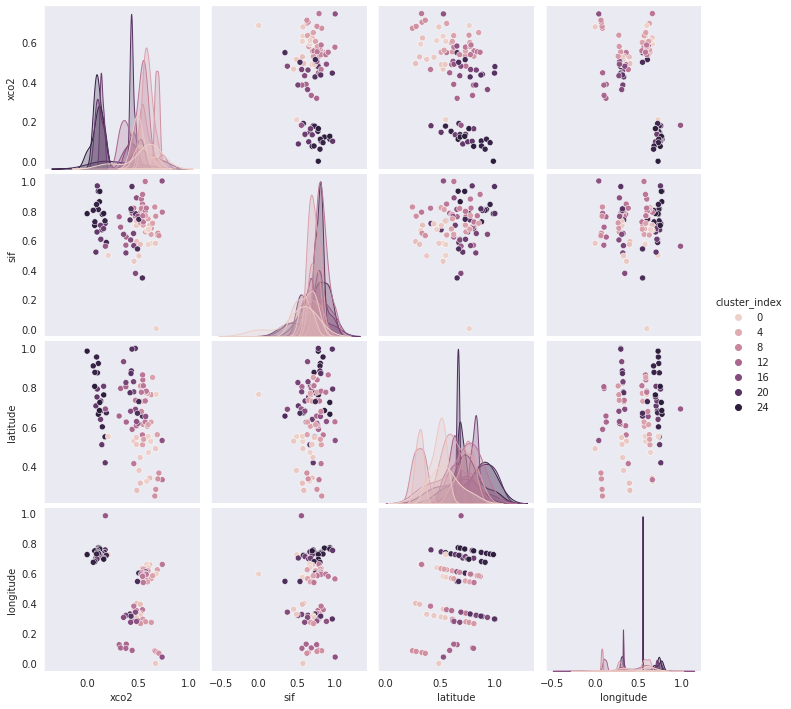

In [ ]:
sns.pairplot(florestals, hue='cluster_index', vars=['xco2','sif','latitude','longitude'])

/usr/local/lib/python3.8/dist-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.8/dist-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/usr/local/lib/python3.8/dist-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/usr/local/lib/python3.8/dist-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


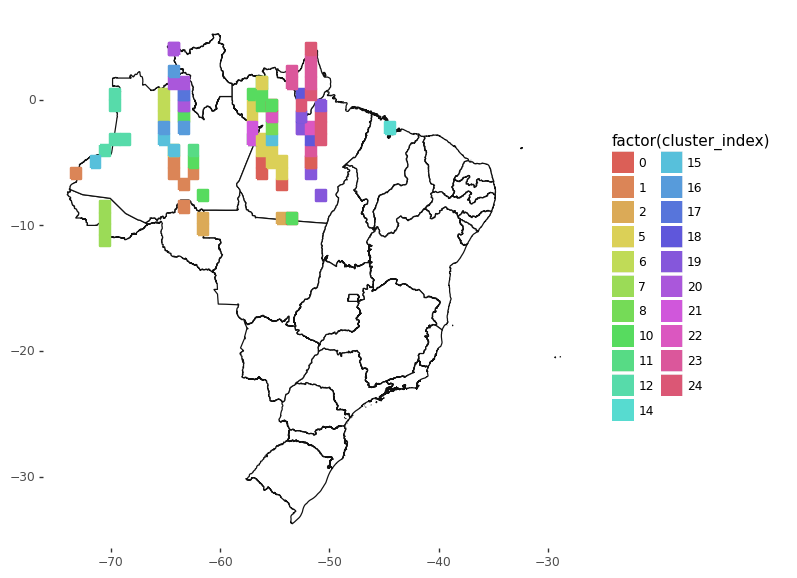

<ggplot: (8737462659967)>

In [ ]:
(
    ggplot() 
    + geom_map(geo_ufs, fill ='white')
    + geom_map(florestals, aes(fill='factor(cluster_index)', color='factor(cluster_index)'), size=1)
    + geom_point()
    + theme(figure_size=(7, 7), panel_background=element_rect(fill='white'))
)

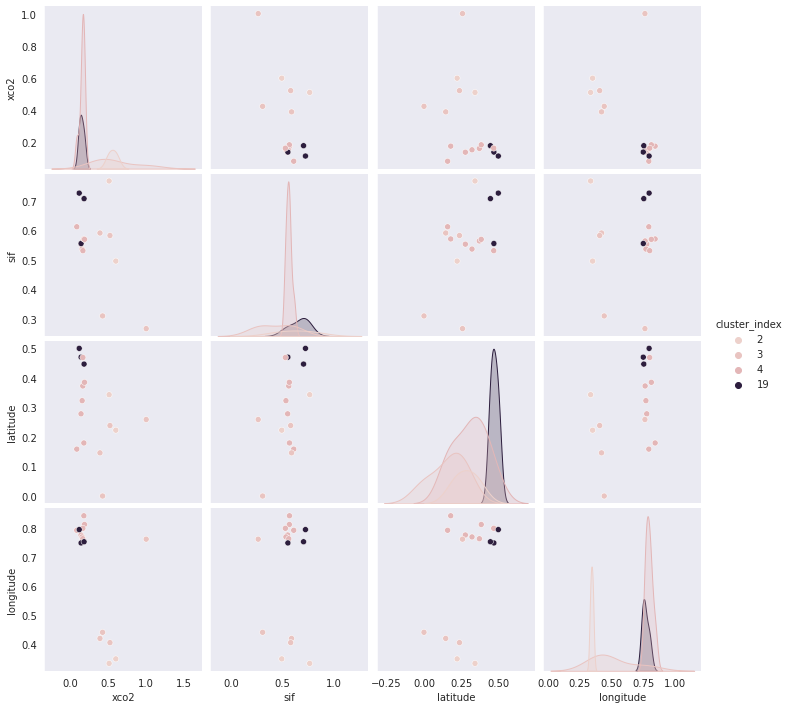

In [ ]:
sns.pairplot(pastagems, hue='cluster_index', vars=['xco2','sif','latitude','longitude'])

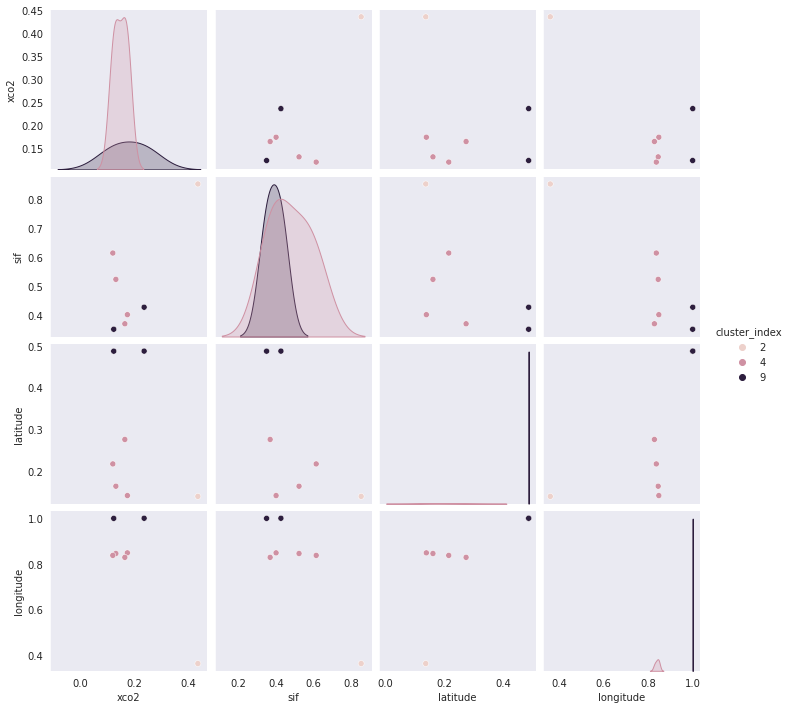

In [ ]:
sns.pairplot(savanicas, hue='cluster_index', vars=['xco2','sif','latitude','longitude'])

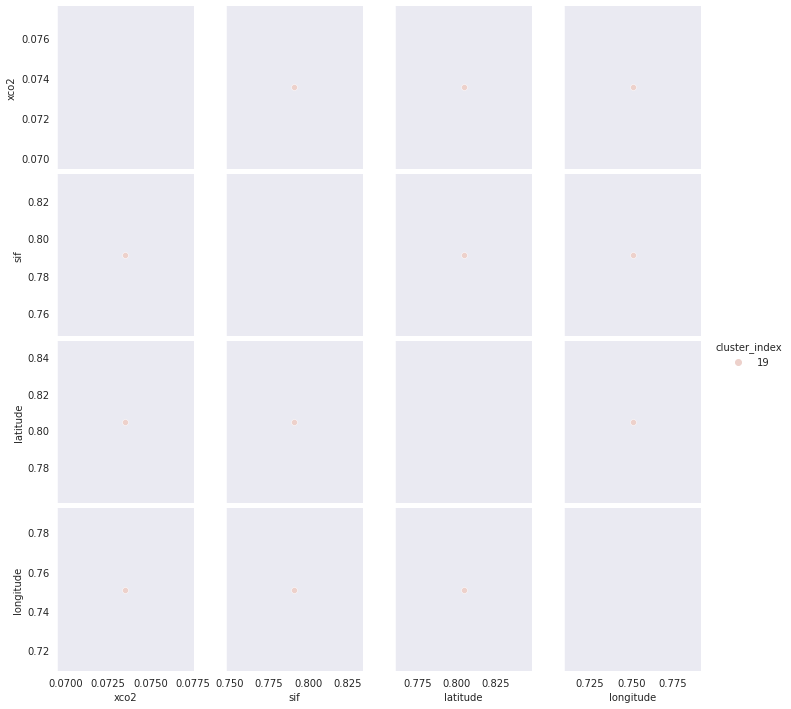

In [ ]:
sns.pairplot(campestres, hue='cluster_index', vars=['xco2','sif','latitude','longitude'])